In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
zero = 1e-24

bias = 0.0
bias_assumed = 0.1

shift = 0
tilt = 0
shift_assumed = zero
tilt_assumed = zero

print(tilt)
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift, 
                        tilt = tilt,
                        resolution = 0,
                        bias = bias,
                        e_reco_creation = 10, 
                        rnd = False)
dataset = sys_.create_dataset()
dataset.models[0].parameters['lon_0'].frozen = True
dataset.models[0].parameters['lat_0'].frozen = True
datasets = Datasets(dataset)    
    
    
dataset_N = sys_.create_dataset_N(10)
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bias_assumed**2, 1/zero**2, 1/shift_assumed**2, 1/tilt_assumed**2])

dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_N.models[0].parameters['lon_0'].frozen = True
dataset_N.models[0].parameters['lat_0'].frozen = True
dataset_N.models.parameters['norm_nuisance'].frozen = True
dataset_N.models.parameters['tilt_nuisance'].frozen = True
dataset_N.models.parameters['resolution'].frozen = True

datasets_N = Datasets(dataset_N)

parlist= ['norm', 'tilt', 'sigma']
for p in parlist:
    datasets.models.parameters[p].frozen = True    
    datasets_N.models.parameters[p].frozen = True

0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0


In [5]:
print(datasets_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                 (frozen):      0.019       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
   

In [6]:
import json

def make_writeable(cc):
    d = dict()
    for ii, seg in enumerate(cc.allsegs[0]):
        d['x'] = seg[:,0].tolist()
        d['y'] = seg[:,1].tolist()
    return d

def save(c, name):
    d = make_writeable(c)
    with open(name, 'w') as f:
        json.dump(d, f)
        
def read(name):
    with open(name) as data_file:
        data_loaded = json.load(data_file)
    return data_loaded

## Standard 

In [7]:
%%time
fitting = False
if fitting :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.01, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets)
    print(result)
    dd
    c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.68, 
                                   size = 100, 
                                   )
    save(c, 'data/5_scan_68.json')
    c95 = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    save(c95, 'data/5_scan_95.json')
else:
    c = read('data/5_scan_68.json')
    c95 = read('data/5_scan_95.json')


CPU times: user 261 µs, sys: 238 µs, total: 499 µs
Wall time: 357 µs


## Nuisance Parameters

In [14]:
%%time
fit_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.1, "strategy": 2}
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run(datasets_N)
print(datasets_N.models)

compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
compute edisp
-0.0006424311926355131
evaluate -0.0006424311926355131
compute exposure
compute edisp
-0.02692454459330322
evaluate -0.02692454459330322
compute exposure
compute edisp
-0.002635094800276363
evaluate -0.002635094800276363
compute e

compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.002284923804160821
evaluate 0.002284923804160821
compute exposure
compute edisp
-0.00364926183103557
evaluate -0.00364926183103557
compute exposure
compute edisp
-8.87504499177353e-05
evaluate -8.87504499177353e-05
compute exposure
compute edisp
-0.0012755875769570135
evaluate -0.0012755875769570135
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.014153295074553603
evaluate 0.014153295074553603
compute exposure
compute edisp
0.014153295074553603
evaluate 0.014153295074553603
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
com

In [ ]:
fit_N.minuit.draw_mnmatrix();

compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459516783684644
evaluate 0.012459516783684644
compute exposure
compute edisp
-0.013823854810559394
evaluate -0.013823854810559394
compute exposure
compute edisp
0.00752112525720816
evaluate 0.00752112525720816
compute exposure
compute edisp
-0.00888546328408291
evaluate -0.00888546328408291
compute exposure
compute edisp
0.041704695779402966
evaluate 0.041704695779402966
compute exposure
compute edisp
-0.043069033806277704
evaluate -0.043069033806277704
compute exposure
compute edisp
0.015159774137905714
evaluate 0.015159774137905714
compute exp

compute edisp
-0.02852400393393792
evaluate -0.02852400393393792
compute exposure
compute edisp
-0.02882782006667124
evaluate -0.02882782006667124
compute exposure
compute edisp
-0.009687403704472151
evaluate -0.009687403704472151
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.122054004609906
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459527876376573
evaluate 0.012459527876376573
compute exposure
compute edisp
-0.013823865903251322
evaluate -0.013823865903251322
compute exposure
compute edisp
0.00765690236664244
evaluate 0.00765690236664244
compute exposure
compute edisp
-0.00902124039351719
evaluate -0.00902124039351719
compute exposure
compute edisp
0.04170473133220073
evaluate 0.04170473133220073
compute exposure
compute edisp
-0.043069069359075465
evaluate -0.043069069359075465
compute exposure
compute edisp
0.015077971054063269
evaluate 0.015077971054063269
compute expos

compute edisp
-0.027187079730817538
evaluate -0.027187079730817538
compute exposure
compute edisp
-0.02701146390939938
evaluate -0.02701146390939938
compute exposure
compute edisp
-0.02695964148341302
evaluate -0.02695964148341302
compute exposure
compute edisp
-0.026941797573772252
evaluate -0.026941797573772252
compute exposure
compute edisp
-0.026935335605367396
evaluate -0.026935335605367396
compute exposure
compute edisp
-0.026932952909868534
evaluate -0.026932952909868534
compute exposure
compute edisp
-0.02693206854377797
evaluate -0.02693206854377797
compute exposure
compute edisp
-0.02693173974601502
evaluate -0.02693173974601502
compute exposure
compute edisp
-0.026931617241190847
evaluate -0.026931617241190847
compute exposure
compute edisp
-0.026931571530111435
evaluate -0.026931571530111435
compute exposure
compute edisp
-0.026931544478852917
evaluate -0.026931544478852917
compute exposure
compute edisp
-0.026931544478852917
evaluate -0.026931544478852917
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.253688474227793
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245953811839744
evaluate 0.01245953811839744
compute exposure
compute edisp
-0.013823876145272189
evaluate -0.013823876145272189
compute exposure
compute edisp
0.007802088012477983
evaluate 0.007802088012477983
compute exposure
compute edisp
-0.009166426039352733
evaluate -0.009166426039352733
compute exposure
compute edisp
0.04170476454102206
evaluate 0.04170476454102206
compute exposure
compute edisp
-0.0430691025678968
evaluate -0.0430691025678968
compute exposure
compute edisp
0.0149982820885296
evaluate 0.0149982820885296
compute exposure
co

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.38532294384568
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459547519307074
evaluate 0.012459547519307074
compute exposure
compute edisp
-0.013823885546181825
evaluate -0.013823885546181825
compute exposure
compute edisp
0.007957611313638315
evaluate 0.007957611313638315
compute exposure
compute edisp
-0.009321949340513065
evaluate -0.009321949340513065
compute exposure
compute edisp
0.04170479487636009
evaluate 0.04170479487636009
compute exposure
compute edisp
-0.04306913290323483
evaluate -0.04306913290323483
compute exposure
compute edisp
0.014920630516536531
evaluate 0.014920630516536531
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.516957413463567
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.0124595560884743
evaluate 0.0124595560884743
compute exposure
compute edisp
-0.01382389411534905
evaluate -0.01382389411534905
compute exposure
compute edisp
0.008124547277177357
evaluate 0.008124547277177357
compute exposure
compute edisp
-0.009488885304052107
evaluate -0.009488885304052107
compute exposure
compute edisp
0.04170482236430702
evaluate 0.04170482236430702
compute exposure
compute edisp
-0.043069160391181756
evaluate -0.043069160391181756
compute exposure
compute edisp
0.014844943903315175
evaluate 0.014844943903315175
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.648591883081455
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245956383508373
evaluate 0.01245956383508373
compute exposure
compute edisp
-0.013823901861958478
evaluate -0.013823901861958478
compute exposure
compute edisp
0.008304146351408142
evaluate 0.008304146351408142
compute exposure
compute edisp
-0.009668484378282891
evaluate -0.009668484378282891
compute exposure
compute edisp
0.041704847293938176
evaluate 0.041704847293938176
compute exposure
compute edisp
-0.043069185320812914
evaluate -0.043069185320812914
compute exposure
compute edisp
0.014771153219323136
evaluate 0.014771153219323136
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.78022635269934
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245957076814029
evaluate 0.01245957076814029
compute exposure
compute edisp
-0.013823908795015041
evaluate -0.013823908795015041
compute exposure
compute edisp
0.008497872022289714
evaluate 0.008497872022289714
compute exposure
compute edisp
-0.009862210049164462
evaluate -0.009862210049164462
compute exposure
compute edisp
0.04170486987176712
evaluate 0.04170486987176712
compute exposure
compute edisp
-0.04306920789864187
evaluate -0.04306920789864187
compute exposure
compute edisp
0.014699192785481723
evaluate 0.014699192785481723
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.911860822317228
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459576896474912
evaluate 0.012459576896474912
compute exposure
compute edisp
-0.01382391492334966
evaluate -0.01382391492334966
compute exposure
compute edisp
0.008707448938916142
evaluate 0.008707448938916142
compute exposure
compute edisp
-0.01007178696579089
evaluate -0.01007178696579089
compute exposure
compute edisp
0.041704889793998244
evaluate 0.041704889793998244
compute exposure
compute edisp
-0.04306922782087298
evaluate -0.04306922782087298
compute exposure
compute edisp
0.014628999749523792
evaluate 0.014628999749523792
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=9.043495291935114
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459582228748947
evaluate 0.012459582228748947
compute exposure
compute edisp
-0.013823920255623696
evaluate -0.013823920255623696
compute exposure
compute edisp
0.008934925116310007
evaluate 0.008934925116310007
compute exposure
compute edisp
-0.010299263143184757
evaluate -0.010299263143184757
compute exposure
compute edisp
0.04170490670166023
evaluate 0.04170490670166023
compute exposure
compute edisp
-0.043069244728534975
evaluate -0.043069244728534975
compute exposure
compute edisp
0.014560514311434878
evaluate 0.014560514311434878
compute e

compute edisp
-0.00504148092196525
evaluate -0.00504148092196525
compute exposure
compute edisp
0.024292526210459704
evaluate 0.024292526210459704
compute exposure
compute edisp
-0.0343754880543902
evaluate -0.0343754880543902
compute exposure
compute edisp
0.01373037215574286
evaluate 0.01373037215574286
compute exposure
compute edisp
-0.02381333399967336
evaluate -0.02381333399967336
compute exposure
compute edisp
0.008105207658434931
evaluate 0.008105207658434931
compute exposure
compute edisp
-0.01818816950236543
evaluate -0.01818816950236543
compute exposure
compute edisp
0.015272768662586573
evaluate 0.015272768662586573
compute exposure
compute edisp
-0.02535573050651707
evaluate -0.02535573050651707
compute exposure
compute edisp
0.0090697650915061
evaluate 0.0090697650915061
compute exposure
compute edisp
-0.0191527269354366
evaluate -0.0191527269354366
compute exposure
compute edisp
-0.001823295002853385
evaluate -0.001823295002853385
compute exposure
compute edisp
-0.0039086

compute edisp
-0.0030027754608219653
evaluate -0.0030027754608219653
compute exposure
compute edisp
-0.003002815095501581
evaluate -0.003002815095501581
compute exposure
compute edisp
-0.003002831528176732
evaluate -0.003002831528176732
compute exposure
compute edisp
-0.003002838247867854
evaluate -0.003002838247867854
compute exposure
compute edisp
-0.0030028428263862623
evaluate -0.0030028428263862623
compute exposure
compute edisp
-0.0030028428263862623
evaluate -0.0030028428263862623
compute exposure
compute edisp
-0.0030028428263862623
evaluate -0.0030028428263862623
compute exposure
compute edisp
0.013039198294448611
evaluate 0.013039198294448611
compute exposure
compute edisp
-0.019044883947221137
evaluate -0.019044883947221137
compute exposure
compute edisp
-0.0030028428263862623
evaluate -0.0030028428263862623
compute exposure
compute edisp
-0.0030028428263862623
evaluate -0.0030028428263862623
compute exposure
compute edisp
-0.0030028428263862623
evaluate -0.00300284282638626

compute edisp
-0.007331100835885997
evaluate -0.007331100835885997
compute exposure
compute edisp
0.015502722681872907
evaluate 0.015502722681872907
compute exposure
compute edisp
-0.030164924353644897
evaluate -0.030164924353644897
compute exposure
compute edisp
0.007813926619816378
evaluate 0.007813926619816378
compute exposure
compute edisp
-0.02247612829158837
evaluate -0.02247612829158837
compute exposure
compute edisp
0.0119001039408796
evaluate 0.0119001039408796
compute exposure
compute edisp
-0.026562305612651597
evaluate -0.026562305612651597
compute exposure
compute edisp
0.015681304251462275
evaluate 0.015681304251462275
compute exposure
compute edisp
-0.030343505923234267
evaluate -0.030343505923234267
compute exposure
compute edisp
0.007917098144890305
evaluate 0.007917098144890305
compute exposure
compute edisp
-0.0225792998166623
evaluate -0.0225792998166623
compute exposure
compute edisp
-0.006908184417224188
evaluate -0.006908184417224188
compute exposure
compute edis

compute edisp
-0.007619339764229685
evaluate -0.007619339764229685
compute exposure
compute edisp
0.013398836937028136
evaluate 0.013398836937028136
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245959353338219
evaluate 0.01245959353338219
compute exposure
compute edisp
-0.01382393156025694
evaluate -0.01382393156025694
compute exposure
compute edisp
0.009751977821372985
evaluate 0.009751977821372985
compute exposure
compute edisp
-0.011116315848247736
evaluate -0.011116315848247736
compute exposure
compute edisp
0.04170494331664168
evaluate 0.04170494331664168
compute expos

compute edisp
-0.0004703186833565646
evaluate -0.0004703186833565646
compute exposure
compute edisp
-0.0004680947301794447
evaluate -0.0004680947301794447
compute exposure
compute edisp
-0.00046707155053779054
evaluate -0.00046707155053779054
compute exposure
compute edisp
-0.0004669489661623941
evaluate -0.0004669489661623941
compute exposure
compute edisp
-0.0004669489661623941
evaluate -0.0004669489661623941
compute exposure
compute edisp
-0.0004669489661623941
evaluate -0.0004669489661623941
compute exposure
compute edisp
0.010277539227491332
evaluate 0.010277539227491332
compute exposure
compute edisp
-0.011211437159816122
evaluate -0.011211437159816122
compute exposure
compute edisp
0.04192020672994495
evaluate 0.04192020672994495
compute exposure
compute edisp
-0.04285410466226974
evaluate -0.04285410466226974
compute exposure
compute edisp
0.014652917507244054
evaluate 0.014652917507244054
compute exposure
compute edisp
-0.015586815439568845
evaluate -0.015586815439568845
compu

compute edisp
-0.0033034152448547668
evaluate -0.0033034152448547668
compute exposure
compute edisp
-0.003305228699481849
evaluate -0.003305228699481849
compute exposure
compute edisp
-0.003305228699481849
evaluate -0.003305228699481849
compute exposure
compute edisp
-0.003305228699481849
evaluate -0.003305228699481849
compute exposure
compute edisp
0.009885156322525672
evaluate 0.009885156322525672
compute exposure
compute edisp
-0.016495613721489367
evaluate -0.016495613721489367
compute exposure
compute edisp
-0.002748296011551659
evaluate -0.002748296011551659
compute exposure
compute edisp
-0.003029627166316979
evaluate -0.003029627166316979
compute exposure
compute edisp
-0.003094476406069385
evaluate -0.003094476406069385
compute exposure
compute edisp
-0.003094476406069385
evaluate -0.003094476406069385
compute exposure
compute edisp
-0.003094476406069385
evaluate -0.003094476406069385
compute exposure
compute edisp
0.011101609554505369
evaluate 0.011101609554505369
compute exp

compute edisp
0.014799952503418127
evaluate 0.014799952503418127
compute exposure
compute edisp
-0.017705813192389817
evaluate -0.017705813192389817
compute exposure
compute edisp
0.01001966371900137
evaluate 0.01001966371900137
compute exposure
compute edisp
-0.012925524407973062
evaluate -0.012925524407973062
compute exposure
compute edisp
-0.001395493037337392
evaluate -0.001395493037337392
compute exposure
compute edisp
-0.001165743808743574
evaluate -0.001165743808743574
compute exposure
compute edisp
-0.0013527557298998103
evaluate -0.0013527557298998103
compute exposure
compute edisp
-0.0013527557298998103
evaluate -0.0013527557298998103
compute exposure
compute edisp
-0.0013527557298998103
evaluate -0.0013527557298998103
compute exposure
compute edisp
0.04103441039371603
evaluate 0.04103441039371603
compute exposure
compute edisp
-0.04373992185351565
evaluate -0.04373992185351565
compute exposure
compute edisp
0.013601524542654344
evaluate 0.013601524542654344
compute exposure


compute edisp
-0.014703853201146871
evaluate -0.014703853201146871
compute exposure
compute edisp
0.01282357468550552
evaluate 0.01282357468550552
compute exposure
compute edisp
-0.00994993943295694
evaluate -0.00994993943295694
compute exposure
compute edisp
0.043823975303909773
evaluate 0.043823975303909773
compute exposure
compute edisp
-0.0409503400513612
evaluate -0.0409503400513612
compute exposure
compute edisp
0.005540568700460098
evaluate 0.005540568700460098
compute exposure
compute edisp
0.003295679861662188
evaluate 0.003295679861662188
compute exposure
compute edisp
0.0023167988093675137
evaluate 0.0023167988093675137
compute exposure
compute edisp
0.001861769497892829
evaluate 0.001861769497892829
compute exposure
compute edisp
0.0016439672722785073
evaluate 0.0016439672722785073
compute exposure
compute edisp
0.0015382544629959412
evaluate 0.0015382544629959412
compute exposure
compute edisp
0.0014865988086264152
evaluate 0.0014865988086264152
compute exposure
compute ed

compute edisp
0.019610704534545602
evaluate 0.019610704534545602
compute exposure
compute edisp
-0.007979964300877048
evaluate -0.007979964300877048
compute exposure
compute edisp
0.004386609246495713
evaluate 0.004386609246495713
compute exposure
compute edisp
0.00492793639386043
evaluate 0.00492793639386043
compute exposure
compute edisp
0.0005118658113885611
evaluate 0.0005118658113885611
compute exposure
compute edisp
0.0005118658113885611
evaluate 0.0005118658113885611
compute exposure
compute edisp
0.0005118658113885611
evaluate 0.0005118658113885611
compute exposure
compute edisp
0.020749713712302324
evaluate 0.020749713712302324
compute exposure
compute edisp
-0.019725982089525203
evaluate -0.019725982089525203
compute exposure
compute edisp
0.014501500602897139
evaluate 0.014501500602897139
compute exposure
compute edisp
-0.013477768980120017
evaluate -0.013477768980120017
compute exposure
compute edisp
0.010469692129430249
evaluate 0.010469692129430249
compute exposure
comput

compute edisp
0.016483688229662615
evaluate 0.016483688229662615
compute exposure
compute edisp
0.014916178986053161
evaluate 0.014916178986053161
compute exposure
compute edisp
0.014136192906618186
evaluate 0.014136192906618186
compute exposure
compute edisp
0.013747925666221296
evaluate 0.013747925666221296
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.491474457731872
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459590664952216
evaluate 0.012459590664952216
compute exposure
compute edisp
-0.013823928691826966
evaluate -0.013823928691826966
compute exposure
compute edisp
0.014037980973279303
evaluate 0.014037980973279303
compute exposure
compute edisp
-0.015402319000154053
evaluate -0.015402319000154053
compute exposure
compute edisp
0.0097229426215482
evaluate 0.0097229426215482
compute exposure
compute edisp
-0.01108728064842295
evaluate -0.01108728064842295
compute exposure
compute edisp
0.041704934084276675
evaluate 0.041704934084276675
compute expos

compute edisp
0.008359152434797039
evaluate 0.008359152434797039
compute exposure
compute edisp
0.006953915870373989
evaluate 0.006953915870373989
compute exposure
compute edisp
0.02522199120787363
evaluate 0.02522199120787363
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459582767080203
evaluate 0.012459582767080203
compute exposure
compute edisp
-0.013823920793954954
evaluate -0.013823920793954954
compute exposure
compute edisp
0.01639859693579656
evaluate 0.01639859693579656
compute exposure
compute edisp
-0.017762934962671312
evaluate -0.017762934962671312
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.886377866585534
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459577779482783
evaluate 0.012459577779482783
compute exposure
compute edisp
-0.013823915806357532
evaluate -0.013823915806357532
compute exposure
compute edisp
0.018122469962826782
evaluate 0.018122469962826782
compute exposure
compute edisp
-0.01948680798970153
evaluate -0.01948680798970153
compute exposure
compute edisp
0.012342302317895817
evaluate 0.012342302317895817
compute exposure
compute edisp
-0.013706640344770567
evaluate -0.013706640344770567
compute exposure
compute edisp
0.017987332434102905
evaluate 0.017987332434102905
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.018012336203421
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459572108291279
evaluate 0.012459572108291279
compute exposure
compute edisp
-0.01382391013516603
evaluate -0.01382391013516603
compute exposure
compute edisp
0.020519784823775047
evaluate 0.020519784823775047
compute exposure
compute edisp
-0.021884122850649796
evaluate -0.021884122850649796
compute exposure
compute edisp
0.013813126229040379
evaluate 0.013813126229040379
compute exposure
compute edisp
-0.015177464255915128
evaluate -0.015177464255915128
compute exposure
compute edisp
0.009551764763599025
evaluate 0.009551764763599025
compute e

compute edisp
-0.02554561093890454
evaluate -0.02554561093890454
compute exposure
compute edisp
0.015951147088208533
evaluate 0.015951147088208533
compute exposure
compute edisp
-0.01731548511508328
evaluate -0.01731548511508328
compute exposure
compute edisp
0.010951136390965911
evaluate 0.010951136390965911
compute exposure
compute edisp
-0.01231547441784066
evaluate -0.01231547441784066
compute exposure
compute edisp
0.04170485362371285
evaluate 0.04170485362371285
compute exposure
compute edisp
-0.04306919165058759
evaluate -0.04306919165058759
compute exposure
compute edisp
0.023616013887614203
evaluate 0.023616013887614203
compute exposure
compute edisp
0.018787327595292877
evaluate 0.018787327595292877
compute exposure
compute edisp
0.018787327595292877
evaluate 0.018787327595292877
compute exposure
compute edisp
0.018787327595292877
evaluate 0.018787327595292877
compute exposure
compute edisp
0.018787327595292877
evaluate 0.018787327595292877
compute exposure
compute edisp
0.01

compute edisp
-0.01382389676787763
evaluate -0.01382389676787763
compute exposure
compute edisp
0.030827421531231667
evaluate 0.030827421531231667
compute exposure
compute edisp
-0.032191759558106416
evaluate -0.032191759558106416
compute exposure
compute edisp
0.017891598846903077
evaluate 0.017891598846903077
compute exposure
compute edisp
-0.019255936873777826
evaluate -0.019255936873777826
compute exposure
compute edisp
0.012186898778128188
evaluate 0.012186898778128188
compute exposure
compute edisp
-0.013551236805002937
evaluate -0.013551236805002937
compute exposure
compute edisp
0.030529849622535823
evaluate 0.030529849622535823
compute exposure
compute edisp
-0.03189418764941057
evaluate -0.03189418764941057
compute exposure
compute edisp
0.023903802256554117
evaluate 0.023903802256554117
compute exposure
compute edisp
0.019302611362853363
evaluate 0.019302611362853363
compute exposure
compute edisp
0.019302611362853363
evaluate 0.019302611362853363
compute exposure
compute ed

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.41291574505708
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245955105757721
evaluate 0.01245955105757721
compute exposure
compute edisp
-0.01382388908445196
evaluate -0.01382388908445196
compute exposure
compute edisp
0.0497336967325787
evaluate 0.0497336967325787
compute exposure
compute edisp
-0.05109803475945344
evaluate -0.05109803475945344
compute exposure
compute edisp
0.01588056867563351
evaluate 0.01588056867563351
compute exposure
compute edisp
-0.017244906702508257
evaluate -0.017244906702508257
compute exposure
compute edisp
0.010902468998848015
evaluate 0.010902468998848015
compute exposure
co

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.544550214674969
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459542715905086
evaluate 0.012459542715905086
compute exposure
compute edisp
-0.013823880742779834
evaluate -0.013823880742779834
compute exposure
compute edisp
0.0661979285543239
evaluate 0.0661979285543239
compute exposure
compute edisp
-0.06756226658119864
evaluate -0.06756226658119864
compute exposure
compute edisp
0.014927105918461284
evaluate 0.014927105918461284
compute exposure
compute edisp
-0.016291443945336034
evaluate -0.016291443945336034
compute exposure
compute edisp
0.01028158803821795
evaluate 0.01028158803821795
compute exposur

compute edisp
0.040205034775158965
evaluate 0.040205034775158965
compute exposure
compute edisp
0.040204575690631586
evaluate 0.040204575690631586
compute exposure
compute edisp
0.04020439016438429
evaluate 0.04020439016438429
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.055550864469349905
evaluate 0.055550864469349905
compute exposure
compute edisp
0.02485766401051957
evaluate 0.02485766401051957
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.040204264239934735
evaluate 0.040204264239934735
compute exposure
compute edisp
0.0432

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.676184684292856
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245953372206634
evaluate 0.01245953372206634
compute exposure
compute edisp
-0.013823871748941091
evaluate -0.013823871748941091
compute exposure
compute edisp
0.03374624043768094
evaluate 0.03374624043768094
compute exposure
compute edisp
-0.03511057846455569
evaluate -0.03511057846455569
compute exposure
compute edisp
0.01917012531731189
evaluate 0.01917012531731189
compute exposure
compute edisp
-0.02053446334418664
evaluate -0.02053446334418664
compute exposure
compute edisp
0.012983779143960428
evaluate 0.012983779143960428
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.807819153910742
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459524082042575
evaluate 0.012459524082042575
compute exposure
compute edisp
-0.013823862108917324
evaluate -0.013823862108917324
compute exposure
compute edisp
0.02542886491081639
evaluate 0.02542886491081639
compute exposure
compute edisp
-0.026793202937691142
evaluate -0.026793202937691142
compute exposure
compute edisp
0.016239867316128653
evaluate 0.016239867316128653
compute exposure
compute edisp
-0.017604205343003405
evaluate -0.017604205343003405
compute exposure
compute edisp
0.011138101975732721
evaluate 0.011138101975732721
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.93945362352863
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459382853906574
evaluate 0.012459382853906574
compute exposure
compute edisp
-0.013823720880781322
evaluate -0.013823720880781322
compute exposure
compute edisp
0.006640064439595571
evaluate 0.006640064439595571
compute exposure
compute edisp
-0.008004402466470321
evaluate -0.008004402466470321
compute exposure
compute edisp
0.041704263872120916
evaluate 0.041704263872120916
compute exposure
compute edisp
-0.04306860189899566
evaluate -0.04306860189899566
compute exposure
compute edisp
0.015974078924014944
evaluate 0.015974078924014944
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=6.976834118934289
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459412685837664
evaluate 0.012459412685837664
compute exposure
compute edisp
-0.013823750712712413
evaluate -0.013823750712712413
compute exposure
compute edisp
0.006769058288406922
evaluate 0.006769058288406922
compute exposure
compute edisp
-0.008133396315281672
evaluate -0.008133396315281672
compute exposure
compute edisp
0.04170436027513656
evaluate 0.04170436027513656
compute exposure
compute edisp
-0.0430686983020113
evaluate -0.0430686983020113
compute exposure
compute edisp
0.015808963308258615
evaluate 0.015808963308258615
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.187449270322909
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459440121793078
evaluate 0.012459440121793078
compute exposure
compute edisp
-0.013823778148667826
evaluate -0.013823778148667826
compute exposure
compute edisp
0.006911120547606342
evaluate 0.006911120547606342
compute exposure
compute edisp
-0.008275458574481092
evaluate -0.008275458574481092
compute exposure
compute edisp
0.04170444861683183
evaluate 0.04170444861683183
compute exposure
compute edisp
-0.043068786643706565
evaluate -0.043068786643706565
compute exposure
compute edisp
0.015651285038532407
evaluate 0.015651285038532407
compute e

compute edisp
-0.04010997371250282
evaluate -0.04010997371250282
compute exposure
compute edisp
-0.0400835421946001
evaluate -0.0400835421946001
compute exposure
compute edisp
-0.040076459884589806
evaluate -0.040076459884589806
compute exposure
compute edisp
-0.040076459884589806
evaluate -0.040076459884589806
compute exposure
compute edisp
-0.040076459884589806
evaluate -0.040076459884589806
compute exposure
compute edisp
-0.02209586904091343
evaluate -0.02209586904091343
compute exposure
compute edisp
-0.05805705072826618
evaluate -0.05805705072826618
compute exposure
compute edisp
-0.040135567922643715
evaluate -0.040135567922643715
compute exposure
compute edisp
-0.040090113619822454
evaluate -0.040090113619822454
compute exposure
compute edisp
-0.04008036671600995
evaluate -0.04008036671600995
compute exposure
compute edisp
-0.040077638093107125
evaluate -0.040077638093107125
compute exposure
compute edisp
-0.04007682057542147
evaluate -0.04007682057542147
compute exposure
comput

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.398064421711528
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245946520791617
evaluate 0.01245946520791617
compute exposure
compute edisp
-0.013823803234790918
evaluate -0.013823803234790918
compute exposure
compute edisp
0.007067647082211854
evaluate 0.007067647082211854
compute exposure
compute edisp
-0.008431985109086604
evaluate -0.008431985109086604
compute exposure
compute edisp
0.04170452968342902
evaluate 0.04170452968342902
compute exposure
compute edisp
-0.043068867710303764
evaluate -0.043068867710303764
compute exposure
compute edisp
0.015500570697280983
evaluate 0.015500570697280983
compute exp

compute edisp
-0.06449909305540275
evaluate -0.06449909305540275
compute exposure
compute edisp
-0.0395275443075321
evaluate -0.0395275443075321
compute exposure
compute edisp
-0.039976847770529525
evaluate -0.039976847770529525
compute exposure
compute edisp
-0.039999312943679394
evaluate -0.039999312943679394
compute exposure
compute edisp
-0.04000043620233689
evaluate -0.04000043620233689
compute exposure
compute edisp
-0.04000043620233689
evaluate -0.04000043620233689
compute exposure
compute edisp
-0.04000043620233689
evaluate -0.04000043620233689
compute exposure
compute edisp
-0.015556923106920601
evaluate -0.015556923106920601
compute exposure
compute edisp
-0.06444394929775318
evaluate -0.06444394929775318
compute exposure
compute edisp
-0.0399721861532038
evaluate -0.0399721861532038
compute exposure
compute edisp
-0.03999902369988023
evaluate -0.03999902369988023
compute exposure
compute edisp
-0.04000036557721406
evaluate -0.04000036557721406
compute exposure
compute edisp


compute edisp
-6.7527463377327575
evaluate -6.7527463377327575
compute exposure
compute edisp
-3.353873652683388
evaluate -3.353873652683388
compute exposure
compute edisp
-1.6841691742464306
evaluate -1.6841691742464306
compute exposure
compute edisp
-0.8566440886504785
evaluate -0.8566440886504785
compute exposure
compute edisp
-0.4447244219631593
evaluate -0.4447244219631593
compute exposure
compute edisp
-0.24141569594588652
evaluate -0.24141569594588652
compute exposure
compute edisp
-0.14049341475254296
evaluate -0.14049341475254296
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.608679573100147
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459487988773681
evaluate 0.012459487988773681
compute exposure
compute edisp
-0.013823826015648431
evaluate -0.013823826015648431
compute exposure
compute edisp
0.007240332325999123
evaluate 0.007240332325999123
compute exposure
compute edisp
-0.008604670352873873
evaluate -0.008604670352873873
compute exposure
compute edisp
0.0417046027332599
evaluate 0.0417046027332599
compute exposure
compute edisp
-0.043068940760134636
evaluate -0.043068940760134636
compute exposure
compute edisp
0.015356386846835187
evaluate 0.015356386846835187
compute exp

compute edisp
-0.04106473858700266
evaluate -0.04106473858700266
compute exposure
compute edisp
-0.03985627993014834
evaluate -0.03985627993014834
compute exposure
compute edisp
-0.04025909948243312
evaluate -0.04025909948243312
compute exposure
compute edisp
-0.04001740775106225
evaluate -0.04001740775106225
compute exposure
compute edisp
-0.040097971661519204
evaluate -0.040097971661519204
compute exposure
compute edisp
-0.01488146768849246
evaluate -0.01488146768849246
compute exposure
compute edisp
-1.0690309240037612
evaluate -1.0690309240037612
compute exposure
compute edisp
-0.21484594397642653
evaluate -0.21484594397642653
compute exposure
compute edisp
-0.1001891576552608
evaluate -0.1001891576552608
compute exposure
compute edisp
-0.06588791489350795
evaluate -0.06588791489350795
compute exposure
compute edisp
-0.052205792156318154
evaluate -0.052205792156318154
compute exposure
compute edisp
-0.04585828385215573
evaluate -0.04585828385215573
compute exposure
compute edisp
-0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.819294724488766
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245950850743506
evaluate 0.01245950850743506
compute exposure
compute edisp
-0.013823846534309809
evaluate -0.013823846534309809
compute exposure
compute edisp
0.007431242759168473
evaluate 0.007431242759168473
compute exposure
compute edisp
-0.008795580786043223
evaluate -0.008795580786043223
compute exposure
compute edisp
0.041704669075445254
evaluate 0.041704669075445254
compute exposure
compute edisp
-0.04306900710231999
evaluate -0.04306900710231999
compute exposure
compute edisp
0.015218336716267123
evaluate 0.015218336716267123
compute exp

compute edisp
-0.047361975308697
evaluate -0.047361975308697
compute exposure
compute edisp
-0.01539680795417142
evaluate -0.01539680795417142
compute exposure
compute edisp
-0.0412039047101227
evaluate -0.0412039047101227
compute exposure
compute edisp
-0.027830710542531417
evaluate -0.027830710542531417
compute exposure
compute edisp
-0.027915692980576244
evaluate -0.027915692980576244
compute exposure
compute edisp
-0.026307069025798605
evaluate -0.026307069025798605
compute exposure
compute edisp
-0.02706888978416501
evaluate -0.02706888978416501
compute exposure
compute edisp
-0.02633055131527939
evaluate -0.02633055131527939
compute exposure
compute edisp
-0.0266997205497222
evaluate -0.0266997205497222
compute exposure
compute edisp
-0.026354033604760168
evaluate -0.026354033604760168
compute exposure
compute edisp
-0.026526877077241183
evaluate -0.026526877077241183
compute exposure
compute edisp
-0.02661329881348169
evaluate -0.02661329881348169
compute exposure
compute edisp


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.029909875877385
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459526805546938
evaluate 0.012459526805546938
compute exposure
compute edisp
-0.013823864832421689
evaluate -0.013823864832421689
compute exposure
compute edisp
0.007642915518576775
evaluate 0.007642915518576775
compute exposure
compute edisp
-0.009007253545451524
evaluate -0.009007253545451524
compute exposure
compute edisp
0.04170472810931373
evaluate 0.04170472810931373
compute exposure
compute edisp
-0.04306906613618847
evaluate -0.04306906613618847
compute exposure
compute edisp
0.015086055058181447
evaluate 0.015086055058181447
compute exp

compute edisp
-0.02670221913592499
evaluate -0.02670221913592499
compute exposure
compute edisp
-0.026662948726511683
evaluate -0.026662948726511683
compute exposure
compute edisp
-0.026676038862982785
evaluate -0.026676038862982785
compute exposure
compute edisp
-0.026668184781100127
evaluate -0.026668184781100127
compute exposure
compute edisp
-0.026670802808394345
evaluate -0.026670802808394345
compute exposure
compute edisp
-0.006216155558650951
evaluate -0.006216155558650951
compute exposure
compute edisp
-0.4157410875936839
evaluate -0.4157410875936839
compute exposure
compute edisp
-0.1568703355144395
evaluate -0.1568703355144395
compute exposure
compute edisp
-0.08442221672996221
evaluate -0.08442221672996221
compute exposure
compute edisp
-0.054059688078769305
evaluate -0.054059688078769305
compute exposure
compute edisp
-0.03996248349587714
evaluate -0.03996248349587714
compute exposure
compute edisp
-0.033197913509106204
evaluate -0.033197913509106204
compute exposure
comput

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.240525027266004
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459542923401193
evaluate 0.012459542923401193
compute exposure
compute edisp
-0.013823880950275941
evaluate -0.013823880950275941
compute exposure
compute edisp
0.007878493992284435
evaluate 0.007878493992284435
compute exposure
compute edisp
-0.009242832019159186
evaluate -0.009242832019159186
compute exposure
compute edisp
0.041704780113631434
evaluate 0.041704780113631434
compute exposure
compute edisp
-0.04306911814050617
evaluate -0.04306911814050617
compute exposure
compute edisp
0.014959206260767004
evaluate 0.014959206260767004
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.451140178654624
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459556900000411
evaluate 0.012459556900000411
compute exposure
compute edisp
-0.01382389492687516
evaluate -0.01382389492687516
compute exposure
compute edisp
0.00814191501000959
evaluate 0.00814191501000959
compute exposure
compute edisp
-0.00950625303688434
evaluate -0.00950625303688434
compute exposure
compute edisp
0.041704825246486034
evaluate 0.041704825246486034
compute exposure
compute edisp
-0.04306916327336078
evaluate -0.04306916327336078
compute exposure
compute edisp
0.014837480688316172
evaluate 0.014837480688316172
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.661755330043244
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459568773117711
evaluate 0.012459568773117711
compute exposure
compute edisp
-0.01382390679999246
evaluate -0.01382390679999246
compute exposure
compute edisp
0.00843817396528032
evaluate 0.00843817396528032
compute exposure
compute edisp
-0.00980251199215507
evaluate -0.00980251199215507
compute exposure
compute edisp
0.041704863411546896
evaluate 0.041704863411546896
compute exposure
compute edisp
-0.04306920143842164
evaluate -0.04306920143842164
compute exposure
compute edisp
0.014720592515588727
evaluate 0.014720592515588727
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.872370481431862
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459578579353724
evaluate 0.012459578579353724
compute exposure
compute edisp
-0.013823916606228472
evaluate -0.013823916606228472
compute exposure
compute edisp
0.008773709483620036
evaluate 0.008773709483620036
compute exposure
compute edisp
-0.010138047510494786
evaluate -0.010138047510494786
compute exposure
compute edisp
0.041704894990885526
evaluate 0.041704894990885526
compute exposure
compute edisp
-0.04306923301776027
evaluate -0.04306923301776027
compute exposure
compute edisp
0.014608277405229485
evaluate 0.014608277405229485
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=9.082985632820481
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459586354189915
evaluate 0.012459586354189915
compute exposure
compute edisp
-0.013823924381064666
evaluate -0.013823924381064666
compute exposure
compute edisp
0.009156974285098278
evaluate 0.009156974285098278
compute exposure
compute edisp
-0.010521312311973029
evaluate -0.010521312311973029
compute exposure
compute edisp
0.04170492002176991
evaluate 0.04170492002176991
compute exposure
compute edisp
-0.04306925804864466
evaluate -0.04306925804864466
compute exposure
compute edisp
0.01450029040734442
evaluate 0.01450029040734442
compute expos

compute edisp
-0.020565725829388995
evaluate -0.020565725829388995
compute exposure
compute edisp
0.02158464295220703
evaluate 0.02158464295220703
compute exposure
compute edisp
-0.029596076658382625
evaluate -0.029596076658382625
compute exposure
compute edisp
0.012786571869971229
evaluate 0.012786571869971229
compute exposure
compute edisp
-0.020798005576146826
evaluate -0.020798005576146826
compute exposure
compute edisp
0.021811013420842875
evaluate 0.021811013420842875
compute exposure
compute edisp
-0.02982244712701847
evaluate -0.02982244712701847
compute exposure
compute edisp
0.012911540931964218
evaluate 0.012911540931964218
compute exposure
compute edisp
-0.02092297463813982
evaluate -0.02092297463813982
compute exposure
compute edisp
-0.003998236259615875
evaluate -0.003998236259615875
compute exposure
compute edisp
-0.00399916075969203
evaluate -0.00399916075969203
compute exposure
compute edisp
-0.00399522794227911
evaluate -0.00399522794227911
compute exposure
compute ed

compute edisp
0.01382394654359251
evaluate 0.01382394654359251
compute exposure
compute edisp
-0.025463844676662326
evaluate -0.025463844676662326
compute exposure
compute edisp
0.007848300979166606
evaluate 0.007848300979166606
compute exposure
compute edisp
-0.019488199112236423
evaluate -0.019488199112236423
compute exposure
compute edisp
0.011237478265920546
evaluate 0.011237478265920546
compute exposure
compute edisp
-0.022877376398990363
evaluate -0.022877376398990363
compute exposure
compute edisp
0.014566788488896684
evaluate 0.014566788488896684
compute exposure
compute edisp
-0.026206686621966502
evaluate -0.026206686621966502
compute exposure
compute edisp
-0.0060808147897025875
evaluate -0.0060808147897025875
compute exposure
compute edisp
-0.005866081578850573
evaluate -0.005866081578850573
compute exposure
compute edisp
-0.005839514419171314
evaluate -0.005839514419171314
compute exposure
compute edisp
-0.0058313244272904085
evaluate -0.0058313244272904085
compute exposur

compute edisp
-0.015468993793596541
evaluate -0.015468993793596541
compute exposure
compute edisp
-0.0023776473766953794
evaluate -0.0023776473766953794
compute exposure
compute edisp
-0.0030867505696471572
evaluate -0.0030867505696471572
compute exposure
compute edisp
-0.003122205729294746
evaluate -0.003122205729294746
compute exposure
compute edisp
-0.003123975410666211
evaluate -0.003123975410666211
compute exposure
compute edisp
-0.003123975410666211
evaluate -0.003123975410666211
compute exposure
compute edisp
-0.003123975410666211
evaluate -0.003123975410666211
compute exposure
compute edisp
0.009863363304367349
evaluate 0.009863363304367349
compute exposure
compute edisp
-0.01611131412569977
evaluate -0.01611131412569977
compute exposure
compute edisp
-0.002550899426196042
evaluate -0.002550899426196042
compute exposure
compute edisp
-0.002840923747994201
evaluate -0.002840923747994201
compute exposure
compute edisp
-0.0029273089353587627
evaluate -0.0029273089353587627
compute

compute edisp
-0.00021319461200141276
evaluate -0.00021319461200141276
compute exposure
compute edisp
-0.00021319461200141276
evaluate -0.00021319461200141276
compute exposure
compute edisp
-0.00021319461200141276
evaluate -0.00021319461200141276
compute exposure
compute edisp
0.013732208134799834
evaluate 0.013732208134799834
compute exposure
compute edisp
-0.014158597358802658
evaluate -0.014158597358802658
compute exposure
compute edisp
0.009722299706430725
evaluate 0.009722299706430725
compute exposure
compute edisp
-0.01014868893043355
evaluate -0.01014868893043355
compute exposure
compute edisp
0.042173964516706866
evaluate 0.042173964516706866
compute exposure
compute edisp
-0.04260035374070969
evaluate -0.04260035374070969
compute exposure
compute edisp
0.014684361771176928
evaluate 0.014684361771176928
compute exposure
compute edisp
-0.015110750995179754
evaluate -0.015110750995179754
compute exposure
compute edisp
0.010359730456566612
evaluate 0.010359730456566612
compute exp

compute edisp
0.0003479733666885787
evaluate 0.0003479733666885787
compute exposure
compute edisp
0.019878200838644774
evaluate 0.019878200838644774
compute exposure
compute edisp
-0.019182254105267617
evaluate -0.019182254105267617
compute exposure
compute edisp
0.013898922165046075
evaluate 0.013898922165046075
compute exposure
compute edisp
-0.013202975431668918
evaluate -0.013202975431668918
compute exposure
compute edisp
0.02102780622930635
evaluate 0.02102780622930635
compute exposure
compute edisp
-0.020331859495929194
evaluate -0.020331859495929194
compute exposure
compute edisp
0.014608524462712607
evaluate 0.014608524462712607
compute exposure
compute edisp
-0.013912577729335449
evaluate -0.013912577729335449
compute exposure
compute edisp
0.010487433302392784
evaluate 0.010487433302392784
compute exposure
compute edisp
-0.009791486569015627
evaluate -0.009791486569015627
compute exposure
compute edisp
0.0003479733666885787
evaluate 0.0003479733666885787
compute exposure
comp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.557291692540817
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459586665986748
evaluate 0.012459586665986748
compute exposure
compute edisp
-0.013823924692861499
evaluate -0.013823924692861499
compute exposure
compute edisp
0.015201026062498622
evaluate 0.015201026062498622
compute exposure
compute edisp
-0.016565364089373372
evaluate -0.016565364089373372
compute exposure
compute edisp
0.010481704490018492
evaluate 0.010481704490018492
compute exposure
compute edisp
-0.011846042516893243
evaluate -0.011846042516893243
compute exposure
compute edisp
0.04170492124056394
evaluate 0.04170492124056394
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.978521995318054
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459570274607026
evaluate 0.012459570274607026
compute exposure
compute edisp
-0.013823908301481776
evaluate -0.013823908301481776
compute exposure
compute edisp
0.021442668270439263
evaluate 0.021442668270439263
compute exposure
compute edisp
-0.02280700629731401
evaluate -0.02280700629731401
compute exposure
compute edisp
0.014364707197594669
evaluate 0.014364707197594669
compute exposure
compute edisp
-0.01572904522446942
evaluate -0.01572904522446942
compute exposure
compute edisp
0.009916271757325065
evaluate 0.009916271757325065
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.189137146706674
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459559472904882
evaluate 0.012459559472904882
compute exposure
compute edisp
-0.013823897499779633
evaluate -0.013823897499779633
compute exposure
compute edisp
0.029911716205400337
evaluate 0.029911716205400337
compute exposure
compute edisp
-0.031276054232275086
evaluate -0.031276054232275086
compute exposure
compute edisp
0.01745440188456574
evaluate 0.01745440188456574
compute exposure
compute edisp
-0.018818739911440494
evaluate -0.018818739911440494
compute exposure
compute edisp
0.011911178935767769
evaluate 0.011911178935767769
compute e

compute edisp
0.0029877676293068233
evaluate 0.0029877676293068233
compute exposure
compute edisp
0.030024703901983498
evaluate 0.030024703901983498
compute exposure
compute edisp
0.026312052911802563
evaluate 0.026312052911802563
compute exposure
compute edisp
0.024186452612984063
evaluate 0.024186452612984063
compute exposure
compute edisp
0.02338576878708601
evaluate 0.02338576878708601
compute exposure
compute edisp
0.02304904476478315
evaluate 0.02304904476478315
compute exposure
compute edisp
0.022900904560688346
evaluate 0.022900904560688346
compute exposure
compute edisp
0.022834438752436525
evaluate 0.022834438752436525
compute exposure
compute edisp
0.022804355148650996
evaluate 0.022804355148650996
compute exposure
compute edisp
0.022790684557884956
evaluate 0.022790684557884956
compute exposure
compute edisp
0.022784461397959463
evaluate 0.022784461397959463
compute exposure
compute edisp
0.02278162602638126
evaluate 0.02278162602638126
compute exposure
compute edisp
0.0227

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.610367449483913
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459532787044371
evaluate 0.012459532787044371
compute exposure
compute edisp
-0.013823870813919122
evaluate -0.013823870813919122
compute exposure
compute edisp
0.03254367617165947
evaluate 0.03254367617165947
compute exposure
compute edisp
-0.033908014198534224
evaluate -0.033908014198534224
compute exposure
compute edisp
0.018620339782745007
evaluate 0.018620339782745007
compute exposure
compute edisp
-0.01998467780961976
evaluate -0.01998467780961976
compute exposure
compute edisp
0.01264340030765474
evaluate 0.01264340030765474
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.820982600872533
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245951695270184
evaluate 0.01245951695270184
compute exposure
compute edisp
-0.013823854979576588
evaluate -0.013823854979576588
compute exposure
compute edisp
0.022231633579547844
evaluate 0.022231633579547844
compute exposure
compute edisp
-0.023595971606422596
evaluate -0.023595971606422596
compute exposure
compute edisp
0.014831386829046219
evaluate 0.014831386829046219
compute exposure
compute edisp
-0.016195724855920968
evaluate -0.016195724855920968
compute exposure
compute edisp
0.010224217303422862
evaluate 0.010224217303422862
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.031597752261153
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459499489569337
evaluate 0.012459499489569337
compute exposure
compute edisp
-0.013823837516444087
evaluate -0.013823837516444087
compute exposure
compute edisp
0.017853662629938954
evaluate 0.017853662629938954
compute exposure
compute edisp
-0.019218000656813707
evaluate -0.019218000656813707
compute exposure
compute edisp
0.01217592660981217
evaluate 0.01217592660981217
compute exposure
compute edisp
-0.013540264636686918
evaluate -0.013540264636686918
compute exposure
compute edisp
0.017380115260177763
evaluate 0.017380115260177763
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.24221290364977
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459480421001175
evaluate 0.012459480421001175
compute exposure
compute edisp
-0.013823818447875924
evaluate -0.013823818447875924
compute exposure
compute edisp
0.01528313342316327
evaluate 0.01528313342316327
compute exposure
compute edisp
-0.016647471450038018
evaluate -0.016647471450038018
compute exposure
compute edisp
0.010536067646415011
evaluate 0.010536067646415011
compute exposure
compute edisp
-0.01190040567328976
evaluate -0.01190040567328976
compute exposure
compute edisp
0.041704578309701916
evaluate 0.041704578309701916
compute exp

compute edisp
0.054033539085881356
evaluate 0.054033539085881356
compute exposure
compute edisp
0.05482588973648306
evaluate 0.05482588973648306
compute exposure
compute edisp
0.054561772852949164
evaluate 0.054561772852949164
compute exposure
compute edisp
0.07120113651558499
evaluate 0.07120113651558499
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.45282805503839
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245945976977079
evaluate 0.01245945976977079
compute exposure
compute edisp
-0.013823797796645538
evaluate -0.013823797796645538
compute exposure
compute edisp
-0.013823797796645538
evaluate -0.013823797796645538
compute exposure
compute edisp
-0.0663903129294782
evaluate -0.0663903129294782
compute exposure
compute edisp
-0.021666386645576786
evaluate -0.021666386645576786
compute exposure
compute edisp
-0.016418287915404832
evaluate -0.016418287915404832
compute exposure
compute edisp
1.2552974293367214e-09
evaluate 1.2552974293367214e-09
compu

compute edisp
0.05655762058497736
evaluate 0.05655762058497736
compute exposure
compute edisp
0.05655620157136983
evaluate 0.05655620157136983
compute exposure
compute edisp
0.05655565176207497
evaluate 0.05655565176207497
compute exposure
compute edisp
0.056555438990334606
evaluate 0.056555438990334606
compute exposure
compute edisp
0.05655530457305734
evaluate 0.05655530457305734
compute exposure
compute edisp
0.05655530457305734
evaluate 0.05655530457305734
compute exposure
compute edisp
0.05655530457305734
evaluate 0.05655530457305734
compute exposure
compute edisp
0.08001045109745292
evaluate 0.08001045109745292
compute exposure
compute edisp
0.03310015804866175
evaluate 0.03310015804866175
compute exposure
compute edisp
0.05655530457305734
evaluate 0.05655530457305734
compute exposure
compute edisp
0.05655530457305734
evaluate 0.05655530457305734
compute exposure
compute edisp
0.05655530457305734
evaluate 0.05655530457305734
compute exposure
compute edisp
0.05655530457305734
eval

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.663443206427008
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459437558091507
evaluate 0.012459437558091507
compute exposure
compute edisp
-0.013823775584966256
evaluate -0.013823775584966256
compute exposure
compute edisp
-0.013823775584966256
evaluate -0.013823775584966256
compute exposure
compute edisp
-0.06639020187108177
evaluate -0.06639020187108177
compute exposure
compute edisp
-0.02332172959134859
evaluate -0.02332172959134859
compute exposure
compute edisp
-0.017301289720375864
evaluate -0.017301289720375864
compute exposure
compute edisp
3.8917917916103665e-11
evaluate 3.8917917916103665e-11
com

compute edisp
0.032398500902526384
evaluate 0.032398500902526384
compute exposure
compute edisp
0.06726027090727581
evaluate 0.06726027090727581
compute exposure
compute edisp
0.05529728896819152
evaluate 0.05529728896819152
compute exposure
compute edisp
0.054476384470022364
evaluate 0.054476384470022364
compute exposure
compute edisp
0.05426293316075261
evaluate 0.05426293316075261
compute exposure
compute edisp
0.05418085089509599
evaluate 0.05418085089509599
compute exposure
compute edisp
0.05414474590475792
evaluate 0.05414474590475792
compute exposure
compute edisp
0.05412793206724729
evaluate 0.05412793206724729
compute exposure
compute edisp
0.05411989419134724
evaluate 0.05411989419134724
compute exposure
compute edisp
0.05411600350113369
evaluate 0.05411600350113369
compute exposure
compute edisp
0.054114108890495734
evaluate 0.054114108890495734
compute exposure
compute edisp
0.054113183536195084
evaluate 0.054113183536195084
compute exposure
compute edisp
0.0541122972746390

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.874058357815628
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459413807636648
evaluate 0.012459413807636648
compute exposure
compute edisp
-0.013823751834511398
evaluate -0.013823751834511398
compute exposure
compute edisp
-0.013823751834511398
evaluate -0.013823751834511398
compute exposure
compute edisp
-0.06639008311880748
evaluate -0.06639008311880748
compute exposure
compute edisp
-0.0247715050219461
evaluate -0.0247715050219461
compute exposure
compute edisp
-0.018076922109668953
evaluate -0.018076922109668953
compute exposure
compute edisp
1.070317881685101e-09
evaluate 1.070317881685101e-09
compute

compute edisp
0.08610630387740675
evaluate 0.08610630387740675
compute exposure
compute edisp
0.04807947844708158
evaluate 0.04807947844708158
compute exposure
compute edisp
0.08302528285882849
evaluate 0.08302528285882849
compute exposure
compute edisp
0.05116049946565985
evaluate 0.05116049946565985
compute exposure
compute edisp
0.08073360415697879
evaluate 0.08073360415697879
compute exposure
compute edisp
0.05345217816750955
evaluate 0.05345217816750955
compute exposure
compute edisp
0.08716527599484347
evaluate 0.08716527599484347
compute exposure
compute edisp
0.04702050632964485
evaluate 0.04702050632964485
compute exposure
compute edisp
0.08377824141282084
evaluate 0.08377824141282084
compute exposure
compute edisp
0.05040754091166751
evaluate 0.05040754091166751
compute exposure
compute edisp
0.06799789945872604
evaluate 0.06799789945872604
compute exposure
compute edisp
0.06745394701243322
evaluate 0.06745394701243322
compute exposure
compute edisp
0.06726568618854306
evalua

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=13.084673509204247
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459014474275188
evaluate 0.012459014474275188
compute exposure
compute edisp
-0.013823352501149938
evaluate -0.013823352501149938
compute exposure
compute edisp
0.0059441942340495825
evaluate 0.0059441942340495825
compute exposure
compute edisp
-0.007308532260924332
evaluate -0.007308532260924332
compute exposure
compute edisp
0.04170307568149359
evaluate 0.04170307568149359
compute exposure
compute edisp
-0.04306741370836833
evaluate -0.04306741370836833
compute exposure
compute edisp
0.01782004647607033
evaluate 0.01782004647607033
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=5.1444823018533015
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459097733893034
evaluate 0.012459097733893034
compute exposure
compute edisp
-0.013823435760767784
evaluate -0.013823435760767784
compute exposure
compute edisp
0.006022558089104606
evaluate 0.006022558089104606
compute exposure
compute edisp
-0.007386896115979356
evaluate -0.007386896115979356
compute exposure
compute edisp
0.041703343964245056
evaluate 0.041703343964245056
compute exposure
compute edisp
-0.043067681991119794
evaluate -0.043067681991119794
compute exposure
compute edisp
0.017413208733926457
evaluate 0.017413208733926457
compute

compute edisp
-0.0672548186296326
evaluate -0.0672548186296326
compute exposure
compute edisp
-0.06667592226700327
evaluate -0.06667592226700327
compute exposure
compute edisp
-0.06715893746011323
evaluate -0.06715893746011323
compute exposure
compute edisp
-0.05750882012786685
evaluate -0.05750882012786685
compute exposure
compute edisp
-0.06547397415659385
evaluate -0.06547397415659385
compute exposure
compute edisp
-0.06684525707821003
evaluate -0.06684525707821003
compute exposure
compute edisp
-0.06684525707821003
evaluate -0.06684525707821003
compute exposure
compute edisp
-0.06684525707821003
evaluate -0.06684525707821003
compute exposure
compute edisp
-0.06443018111266022
evaluate -0.06443018111266022
compute exposure
compute edisp
-0.06926033304375984
evaluate -0.06926033304375984
compute exposure
compute edisp
-0.06511644117054201
evaluate -0.06511644117054201
compute exposure
compute edisp
-0.06857407298587805
evaluate -0.06857407298587805
compute exposure
compute edisp
-0.0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=5.481466544075092
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459173722223413
evaluate 0.012459173722223413
compute exposure
compute edisp
-0.013823511749098164
evaluate -0.013823511749098164
compute exposure
compute edisp
0.006121795911903434
evaluate 0.006121795911903434
compute exposure
compute edisp
-0.0074861339387781835
evaluate -0.0074861339387781835
compute exposure
compute edisp
0.04170358937464284
evaluate 0.04170358937464284
compute exposure
compute edisp
-0.043067927401517575
evaluate -0.043067927401517575
compute exposure
compute edisp
0.017041122463484135
evaluate 0.017041122463484135
compute

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=5.818450786296883
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459242693103697
evaluate 0.012459242693103697
compute exposure
compute edisp
-0.013823580719978445
evaluate -0.013823580719978445
compute exposure
compute edisp
0.006242781667987788
evaluate 0.006242781667987788
compute exposure
compute edisp
-0.007607119694862538
evaluate -0.007607119694862538
compute exposure
compute edisp
0.04170381177748036
evaluate 0.04170381177748036
compute exposure
compute edisp
-0.043068149804355096
evaluate -0.043068149804355096
compute exposure
compute edisp
0.016699564262948878
evaluate 0.016699564262948878
compute exposure
compute edisp
-0.018063902289823627
evaluate -0.018063902289823627
compute exposure
compute edisp
0.012717740445178429
evaluate 0.012717740445178429
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=6.155435028518674
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459304884593693
evaluate 0.012459304884593693
compute exposure
compute edisp
-0.013823642911468441
evaluate -0.013823642911468441
compute exposure
compute edisp
0.0063870560896589655
evaluate 0.0063870560896589655
compute exposure
compute edisp
-0.007751394116533716
evaluate -0.007751394116533716
compute exposure
compute edisp
0.041704012449595956
evaluate 0.041704012449595956
compute exposure
compute edisp
-0.0430683504764707
evaluate -0.0430683504764707
compute exposure
compute edisp
0.016384981270615436
evaluate 0.016384981270615436
compute exposure
compute edisp
-0.017749319297490185
evaluate -0.017749319297490185
compute exposure
compute edisp
0.012313301144708235
evaluate 0.012313301144708235
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=6.492419270740465
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459360520419302
evaluate 0.012459360520419302
compute exposure
compute edisp
-0.013823698547294053
evaluate -0.013823698547294053
compute exposure
compute edisp
0.006556918847936695
evaluate 0.006556918847936695
compute exposure
compute edisp
-0.007921256874811444
evaluate -0.007921256874811444
compute exposure
compute edisp
0.04170419151817483
evaluate 0.04170419151817483
compute exposure
compute edisp
-0.04306852954504957
evaluate -0.04306852954504957
compute exposure
compute edisp
0.016094360752525603
evaluate 0.016094360752525603
compute exp

compute edisp
-0.054499341449251115
evaluate -0.054499341449251115
compute exposure
compute edisp
-0.0523253613862406
evaluate -0.0523253613862406
compute exposure
compute edisp
-0.05341235141774586
evaluate -0.05341235141774586
compute exposure
compute edisp
-0.052347101186870706
evaluate -0.052347101186870706
compute exposure
compute edisp
-0.052879726302308284
evaluate -0.052879726302308284
compute exposure
compute edisp
-0.05314603886002708
evaluate -0.05314603886002708
compute exposure
compute edisp
-0.053279195138886466
evaluate -0.053279195138886466
compute exposure
compute edisp
-0.05341235141774586
evaluate -0.05341235141774586
compute exposure
compute edisp
-0.05341235141774586
evaluate -0.05341235141774586
compute exposure
compute edisp
-0.032596384529547065
evaluate -0.032596384529547065
compute exposure
compute edisp
-0.07422831830594466
evaluate -0.07422831830594466
compute exposure
compute edisp
-0.03758462799170302
evaluate -0.03758462799170302
compute exposure
compute 

compute edisp
-0.08012074973665483
evaluate -0.08012074973665483
compute exposure
compute edisp
-0.035698555269940195
evaluate -0.035698555269940195
compute exposure
compute edisp
-0.07097300367842654
evaluate -0.07097300367842654
compute exposure
compute edisp
-0.03988944952632093
evaluate -0.03988944952632093
compute exposure
compute edisp
-0.06678210942204581
evaluate -0.06678210942204581
compute exposure
compute edisp
-0.042861433893734015
evaluate -0.042861433893734015
compute exposure
compute edisp
-0.06381012505463272
evaluate -0.06381012505463272
compute exposure
compute edisp
-0.053335797984696856
evaluate -0.053335797984696856
compute exposure
compute edisp
-0.05333578549249964
evaluate -0.05333578549249964
compute exposure
compute edisp
-0.05333578199886114
evaluate -0.05333578199886114
compute exposure
compute edisp
-0.053335780627109294
evaluate -0.053335780627109294
compute exposure
compute edisp
-0.053335780019676066
evaluate -0.053335780019676066
compute exposure
comput

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=6.829403512962255
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459409811238893
evaluate 0.012459409811238893
compute exposure
compute edisp
-0.013823747838113644
evaluate -0.013823747838113644
compute exposure
compute edisp
0.006755591622354169
evaluate 0.006755591622354169
compute exposure
compute edisp
-0.008119929649228919
evaluate -0.008119929649228919
compute exposure
compute edisp
0.04170435077855393
evaluate 0.04170435077855393
compute exposure
compute edisp
-0.04306868880542867
evaluate -0.04306868880542867
compute exposure
compute edisp
0.015825131975008205
evaluate 0.015825131975008205
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.166387755184046
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245945295576229
evaluate 0.01245945295576229
compute exposure
compute edisp
-0.013823790982637038
evaluate -0.013823790982637038
compute exposure
compute edisp
0.0069874776173052345
evaluate 0.0069874776173052345
compute exposure
compute edisp
-0.008351815644179984
evaluate -0.008351815644179984
compute exposure
compute edisp
0.04170449017104473
evaluate 0.04170449017104473
compute exposure
compute edisp
-0.04306882819791947
evaluate -0.04306882819791947
compute exposure
compute edisp
0.015575085349754485
evaluate 0.015575085349754485
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.5033719974058375
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459490141740543
evaluate 0.012459490141740543
compute exposure
compute edisp
-0.013823828168615293
evaluate -0.013823828168615293
compute exposure
compute edisp
0.007258565460881709
evaluate 0.007258565460881709
compute exposure
compute edisp
-0.00862290348775646
evaluate -0.00862290348775646
compute exposure
compute edisp
0.04170460978580033
evaluate 0.04170460978580033
compute exposure
compute edisp
-0.043068947812675076
evaluate -0.043068947812675076
compute exposure
compute edisp
0.01534231212007756
evaluate 0.01534231212007756
compute expos

compute edisp
-0.019544064881435137
evaluate -0.019544064881435137
compute exposure
compute edisp
-0.01941880399898031
evaluate -0.01941880399898031
compute exposure
compute edisp
-0.019358037020948984
evaluate -0.019358037020948984
compute exposure
compute edisp
-0.01932851336725479
evaluate -0.01932851336725479
compute exposure
compute edisp
-0.01931415898348395
evaluate -0.01931415898348395
compute exposure
compute edisp
-0.01930717751215363
evaluate -0.01930717751215363
compute exposure
compute edisp
-0.019300563262559405
evaluate -0.019300563262559405
compute exposure
compute edisp
-0.019300563262559405
evaluate -0.019300563262559405
compute exposure
compute edisp
-0.019300563262559405
evaluate -0.019300563262559405
compute exposure
compute edisp
-0.010586240004157485
evaluate -0.010586240004157485
compute exposure
compute edisp
-0.02801488652096132
evaluate -0.02801488652096132
compute exposure
compute edisp
-0.019300563262559405
evaluate -0.019300563262559405
compute exposure
co

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.840356239627628
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459521546848235
evaluate 0.012459521546848235
compute exposure
compute edisp
-0.013823859573722983
evaluate -0.013823859573722983
compute exposure
compute edisp
0.007577060011596164
evaluate 0.007577060011596164
compute exposure
compute edisp
-0.008941398038470914
evaluate -0.008941398038470914
compute exposure
compute edisp
0.04170471097316697
evaluate 0.04170471097316697
compute exposure
compute edisp
-0.04306904900004171
evaluate -0.04306904900004171
compute exposure
compute edisp
0.015125154310882538
evaluate 0.015125154310882538
compute exp

compute edisp
-0.028520651233369984
evaluate -0.028520651233369984
compute exposure
compute edisp
-0.027517938731661574
evaluate -0.027517938731661574
compute exposure
compute edisp
-0.027852176232231046
evaluate -0.027852176232231046
compute exposure
compute edisp
-0.0067952136963544294
evaluate -0.0067952136963544294
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.177340481849418
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459547339470873
evaluate 0.012459547339470873
compute exposure
compute edisp
-0.013823885366345623
evaluate -0.013823885366345623
compute exposure
compute edisp
0.007954392890868784
evaluate 0.007954392890868784
compute exposure
compute edisp
-0.009318730917743535
evaluate -0.009318730917743535
compute exposure
compute edisp
0.04170479421483627
evaluate 0.04170479421483627
compute exposure
compute edisp
-0.04306913224171101
evaluate -0.04306913224171101
compute exposure
compute edisp
0.014922164020278655
evaluate 0.014922164020278655
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.514324724071209
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459567679410578
evaluate 0.012459567679410578
compute exposure
compute edisp
-0.013823905706285326
evaluate -0.013823905706285326
compute exposure
compute edisp
0.008406900420105308
evaluate 0.008406900420105308
compute exposure
compute edisp
-0.009771238446980057
evaluate -0.009771238446980057
compute exposure
compute edisp
0.041704860040043874
evaluate 0.041704860040043874
compute exposure
compute edisp
-0.04306919806691861
evaluate -0.04306919806691861
compute exposure
compute edisp
0.014732071404603453
evaluate 0.014732071404603453
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.851308966293
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245958271852153
evaluate 0.01245958271852153
compute exposure
compute edisp
-0.013823920745396281
evaluate -0.013823920745396281
compute exposure
compute edisp
0.008958747585414676
evaluate 0.008958747585414676
compute exposure
compute edisp
-0.010323085612289427
evaluate -0.010323085612289427
compute exposure
compute edisp
0.041704908366223176
evaluate 0.041704908366223176
compute exposure
compute edisp
-0.043069246393097914
evaluate -0.043069246393097914
compute exposure
compute edisp
0.01455375751513376
evaluate 0.01455375751513376
compute exp

compute edisp
0.00847865946902326
evaluate 0.00847865946902326
compute exposure
compute edisp
-0.01975808029917837
evaluate -0.01975808029917837
compute exposure
compute edisp
0.010884515486404551
evaluate 0.010884515486404551
compute exposure
compute edisp
-0.02216393631655966
evaluate -0.02216393631655966
compute exposure
compute edisp
0.013178699330989935
evaluate 0.013178699330989935
compute exposure
compute edisp
-0.024458120161145045
evaluate -0.024458120161145045
compute exposure
compute edisp
0.00819084342928152
evaluate 0.00819084342928152
compute exposure
compute edisp
0.00043731397689789287
evaluate 0.00043731397689789287
compute exposure
compute edisp
-0.00252110839999827
evaluate -0.00252110839999827
compute exposure
compute edisp
-0.00252110839999827
evaluate -0.00252110839999827
compute exposure
compute edisp
-0.00252110839999827
evaluate -0.00252110839999827
compute exposure
compute edisp
0.018309071995901784
evaluate 0.018309071995901784
compute exposure
compute edisp


compute edisp
-0.01787502599656241
evaluate -0.01787502599656241
compute exposure
compute edisp
0.009462720651486163
evaluate 0.009462720651486163
compute exposure
compute edisp
-0.013204305501047826
evaluate -0.013204305501047826
compute exposure
compute edisp
-0.001874130735975985
evaluate -0.001874130735975985
compute exposure
compute edisp
-0.001871903327740327
evaluate -0.001871903327740327
compute exposure
compute edisp
-0.0018712668785875694
evaluate -0.0018712668785875694
compute exposure
compute edisp
-0.0018710129194278316
evaluate -0.0018710129194278316
compute exposure
compute edisp
-0.0018708985248007599
evaluate -0.0018708985248007599
compute exposure
compute edisp
-0.0018708445042173857
evaluate -0.0018708445042173857
compute exposure
compute edisp
-0.0018708181628281201
evaluate -0.0018708181628281201
compute exposure
compute edisp
-0.001870805058206407
evaluate -0.001870805058206407
compute exposure
compute edisp
-0.001870798751945306
evaluate -0.001870798751945306
com

compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459597441854745
evaluate 0.012459597441854745
compute exposure
compute edisp
-0.013823935468729493
evaluate -0.013823935468729493
compute exposure
compute edisp
0.008693050726047407
evaluate 0.008693050726047407
compute exposure
compute edisp
0.003773598465900376
evaluate 0.003773598465900376
compute exposure
compute edisp
0.003773598465900376
evaluate 0.003773598465900376
compute exposure
compute edisp
0.003773598465900376
evaluate 0.003773598465900376
compute exposure
compute edisp
0.01618537551485391
evaluate 0.01618537551485391
compute exposure
compute edisp
-0.00863817858305316
evaluate -0.00863817858305316
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.536230177401954
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459583227988808
evaluate 0.012459583227988808
compute exposure
compute edisp
-0.013823921254863559
evaluate -0.013823921254863559
compute exposure
compute edisp
0.016251633881206456
evaluate 0.016251633881206456
compute exposure
compute edisp
-0.01761597190808121
evaluate -0.01761597190808121
compute exposure
compute edisp
0.01115877226221925
evaluate 0.01115877226221925
compute exposure
compute edisp
-0.012523110289094
evaluate -0.012523110289094
compute exposure
compute edisp
0.04170491001350394
evaluate 0.04170491001350394
compute exposure
co

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.873214419623745
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459569271785143
evaluate 0.012459569271785143
compute exposure
compute edisp
-0.013823907298659892
evaluate -0.013823907298659892
compute exposure
compute edisp
0.0219876834276597
evaluate 0.0219876834276597
compute exposure
compute edisp
-0.023352021454534452
evaluate -0.023352021454534452
compute exposure
compute edisp
0.014686488499347486
evaluate 0.014686488499347486
compute exposure
compute edisp
-0.016050826526222237
evaluate -0.016050826526222237
compute exposure
compute edisp
0.010127827173817333
evaluate 0.010127827173817333
compute exp

compute edisp
0.011046554651159399
evaluate 0.011046554651159399
compute exposure
compute edisp
-0.01241089267803415
evaluate -0.01241089267803415
compute exposure
compute edisp
0.04170480576327831
evaluate 0.04170480576327831
compute exposure
compute edisp
-0.04306914379015305
evaluate -0.04306914379015305
compute exposure
compute edisp
0.028183528812735004
evaluate 0.028183528812735004
compute exposure
compute edisp
0.022071936718491298
evaluate 0.022071936718491298
compute exposure
compute edisp
0.022071936718491298
evaluate 0.022071936718491298
compute exposure
compute edisp
0.022071936718491298
evaluate 0.022071936718491298
compute exposure
compute edisp
0.022071936718491298
evaluate 0.022071936718491298
compute exposure
compute edisp
0.022071936718491298
evaluate 0.022071936718491298
compute exposure
compute edisp
0.03631864229181135
evaluate 0.03631864229181135
compute exposure
compute edisp
0.007825231145171245
evaluate 0.007825231145171245
compute exposure
compute edisp
0.0328

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.547182904067327
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459528209178125
evaluate 0.012459528209178125
compute exposure
compute edisp
-0.013823866236052876
evaluate -0.013823866236052876
compute exposure
compute edisp
0.028129145195516254
evaluate 0.028129145195516254
compute exposure
compute edisp
-0.029493483222391006
evaluate -0.029493483222391006
compute exposure
compute edisp
0.01649371306497781
evaluate 0.01649371306497781
compute exposure
compute edisp
-0.01785805109185256
evaluate -0.01785805109185256
compute exposure
compute edisp
0.011300228501068106
evaluate 0.011300228501068106
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.884167146289117
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.0124595013085079
evaluate 0.0124595013085079
compute exposure
compute edisp
-0.013823839335382648
evaluate -0.013823839335382648
compute exposure
compute edisp
0.018183572453273088
evaluate 0.018183572453273088
compute exposure
compute edisp
-0.019547910480147836
evaluate -0.019547910480147836
compute exposure
compute edisp
0.012382307745489379
evaluate 0.012382307745489379
compute exposure
compute edisp
-0.013746645772364128
evaluate -0.013746645772364128
compute exposure
compute edisp
0.018051034173103577
evaluate 0.018051034173103577
compute exp

compute edisp
0.002649313723733896
evaluate 0.002649313723733896
compute exposure
compute edisp
0.01593119354582554
evaluate 0.01593119354582554
compute exposure
compute edisp
0.00511234849886974
evaluate 0.00511234849886974
compute exposure
compute edisp
0.0105462043484054
evaluate 0.0105462043484054
compute exposure
compute edisp
0.010533450653716405
evaluate 0.010533450653716405
compute exposure
compute edisp
0.010527463481480457
evaluate 0.010527463481480457
compute exposure
compute edisp
0.010524571199073463
evaluate 0.010524571199073463
compute exposure
compute edisp
0.010523154610527993
evaluate 0.010523154610527993
compute exposure
compute edisp
0.010522456174971604
evaluate 0.010522456174971604
compute exposure
compute edisp
0.010522110671095007
evaluate 0.010522110671095007
compute exposure
compute edisp
0.010521939494448174
evaluate 0.010521939494448174
compute exposure
compute edisp
0.010521854635977134
evaluate 0.010521854635977134
compute exposure
compute edisp
0.01052181

compute edisp
0.013867541900305936
evaluate 0.013867541900305936
compute exposure
compute edisp
-0.013728852244605719
evaluate -0.013728852244605719
compute exposure
compute edisp
0.010089469042836648
evaluate 0.010089469042836648
compute exposure
compute edisp
-0.009950779387136432
evaluate -0.009950779387136432
compute exposure
compute edisp
0.04245636179377106
evaluate 0.04245636179377106
compute exposure
compute edisp
-0.042317672138070854
evaluate -0.042317672138070854
compute exposure
compute edisp
0.013867541900724336
evaluate 0.013867541900724336
compute exposure
compute edisp
-0.013728852245024119
evaluate -0.013728852245024119
compute exposure
compute edisp
6.930863739091246e-05
evaluate 6.930863739091246e-05
compute exposure
compute edisp
6.933016850738634e-05
evaluate 6.933016850738634e-05
compute exposure
compute edisp
6.933812884874819e-05
evaluate 6.933812884874819e-05
compute exposure
compute edisp
6.934161612584347e-05
evaluate 6.934161612584347e-05
compute exposure
co

compute edisp
-0.018420768230641763
evaluate -0.018420768230641763
compute exposure
compute edisp
-0.0188318635295939
evaluate -0.0188318635295939
compute exposure
compute edisp
-0.01918369625468605
evaluate -0.01918369625468605
compute exposure
compute edisp
-0.01918369625468605
evaluate -0.01918369625468605
compute exposure
compute edisp
-0.01918369625468605
evaluate -0.01918369625468605
compute exposure
compute edisp
-0.01918369625468605
evaluate -0.01918369625468605
compute exposure
compute edisp
-0.01918369625468605
evaluate -0.01918369625468605
compute exposure
compute edisp
-0.0038047169933958
evaluate -0.0038047169933958
compute exposure
compute edisp
-0.034562675515976304
evaluate -0.034562675515976304
compute exposure
compute edisp
-0.010512923733657569
evaluate -0.010512923733657569
compute exposure
compute edisp
-0.02785446877571453
evaluate -0.02785446877571453
compute exposure
compute edisp
-0.01436336717209406
evaluate -0.01436336717209406
compute exposure
compute edisp


compute edisp
0.06025952934075599
evaluate 0.06025952934075599
compute exposure
compute edisp
-0.132561987481807
evaluate -0.132561987481807
compute exposure
compute edisp
-0.039206309827073106
evaluate -0.039206309827073106
compute exposure
compute edisp
0.007471529000293855
evaluate 0.007471529000293855
compute exposure
compute edisp
0.030810448413977332
evaluate 0.030810448413977332
compute exposure
compute edisp
0.042479908120819074
evaluate 0.042479908120819074
compute exposure
compute edisp
0.048314637974239946
evaluate 0.048314637974239946
compute exposure
compute edisp
0.05414936782766081
evaluate 0.05414936782766081
compute exposure
compute edisp
0.05414936782766081
evaluate 0.05414936782766081
compute exposure
compute edisp
0.06016228392118785
evaluate 0.06016228392118785
compute exposure
compute edisp
0.04813645173413377
evaluate 0.04813645173413377
compute exposure
compute edisp
0.06258811083817223
evaluate 0.06258811083817223
compute exposure
compute edisp
0.04571062481714

compute edisp
0.05463035664140982
evaluate 0.05463035664140982
compute exposure
compute edisp
0.05463035664140982
evaluate 0.05463035664140982
compute exposure
compute edisp
0.06416642629285738
evaluate 0.06416642629285738
compute exposure
compute edisp
0.04509428698996226
evaluate 0.04509428698996226
compute exposure
compute edisp
0.05463035664140982
evaluate 0.05463035664140982
compute exposure
compute edisp
0.05463035664140982
evaluate 0.05463035664140982
compute exposure
compute edisp
0.05463035664140982
evaluate 0.05463035664140982
compute exposure
compute edisp
0.05463035664140982
evaluate 0.05463035664140982
compute exposure
compute edisp
0.056537570571699336
evaluate 0.056537570571699336
compute exposure
compute edisp
0.0527231427111203
evaluate 0.0527231427111203
compute exposure
compute edisp
0.05501179942746772
evaluate 0.05501179942746772
compute exposure
compute edisp
0.05424891385535192
evaluate 0.05424891385535192
compute exposure
compute edisp
0.0547066451986214
evaluat

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.89511987295449
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245939627809378
evaluate 0.01245939627809378
compute exposure
compute edisp
-0.013823734304968529
evaluate -0.013823734304968529
compute exposure
compute edisp
0.01069735321865614
evaluate 0.01069735321865614
compute exposure
compute edisp
-0.01206169124553089
evaluate -0.01206169124553089
compute exposure
compute edisp
0.04170430710682604
evaluate 0.04170430710682604
compute exposure
compute edisp
-0.04306864513370078
evaluate -0.04306864513370078
compute exposure
compute edisp
0.013059233662051715
evaluate 0.013059233662051715
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=13.23210411517628
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459353456103406
evaluate 0.012459353456103406
compute exposure
compute edisp
-0.013823691482978157
evaluate -0.013823691482978157
compute exposure
compute edisp
0.009638887757777779
evaluate 0.009638887757777779
compute exposure
compute edisp
-0.011003225784652529
evaluate -0.011003225784652529
compute exposure
compute edisp
0.04170416904762674
evaluate 0.04170416904762674
compute exposure
compute edisp
-0.04306850707450148
evaluate -0.04306850707450148
compute exposure
compute edisp
0.01297298031187786
evaluate 0.01297298031187786
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=13.569088357398071
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459306868565508
evaluate 0.012459306868565508
compute exposure
compute edisp
-0.013823644895440258
evaluate -0.013823644895440258
compute exposure
compute edisp
0.008824744724398677
evaluate 0.008824744724398677
compute exposure
compute edisp
-0.010189082751273426
evaluate -0.010189082751273426
compute exposure
compute edisp
0.041704018531567966
evaluate 0.041704018531567966
compute exposure
compute edisp
-0.04306835655844271
evaluate -0.04306835655844271
compute exposure
compute edisp
0.012890983416174394
evaluate 0.012890983416174394
compute e

compute edisp
0.06055420533224262
evaluate 0.06055420533224262
compute exposure
compute edisp
0.06793328100661068
evaluate 0.06793328100661068
compute exposure
compute edisp
0.06793328100661068
evaluate 0.06793328100661068
compute exposure
compute edisp
0.06793328100661068
evaluate 0.06793328100661068
compute exposure
compute edisp
0.06793328100661068
evaluate 0.06793328100661068
compute exposure
compute edisp
0.06940909614148429
evaluate 0.06940909614148429
compute exposure
compute edisp
0.06645746587173706
evaluate 0.06645746587173706
compute exposure
compute edisp
0.0682284440335854
evaluate 0.0682284440335854
compute exposure
compute edisp
0.06763811797963595
evaluate 0.06763811797963595
compute exposure
compute edisp
0.06799231361200563
evaluate 0.06799231361200563
compute exposure
compute edisp
0.06787424840121573
evaluate 0.06787424840121573
compute exposure
compute edisp
0.07531235668097874
evaluate 0.07531235668097874
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=13.906072599619861
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245925659503105
evaluate 0.01245925659503105
compute exposure
compute edisp
-0.0138235946219058
evaluate -0.0138235946219058
compute exposure
compute edisp
0.00817354249129378
evaluate 0.00817354249129378
compute exposure
compute edisp
-0.009537880518168531
evaluate -0.009537880518168531
compute exposure
compute edisp
0.041703856378187125
evaluate 0.041703856378187125
compute exposure
compute edisp
-0.04306819440506186
evaluate -0.04306819440506186
compute exposure
compute edisp
0.012813000610969705
evaluate 0.012813000610969705
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=14.243056841841653
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245920271216439
evaluate 0.01245920271216439
compute exposure
compute edisp
-0.01382354073903914
evaluate -0.01382354073903914
compute exposure
compute edisp
0.007637440273334085
evaluate 0.007637440273334085
compute exposure
compute edisp
-0.009001778300208835
evaluate -0.009001778300208835
compute exposure
compute edisp
0.041703682672292124
evaluate 0.041703682672292124
compute exposure
compute edisp
-0.04306802069916686
evaluate -0.04306802069916686
compute exposure
compute edisp
0.012738808665846424
evaluate 0.012738808665846424
compute expos

compute edisp
-0.01382348332076684
evaluate -0.01382348332076684
compute exposure
compute edisp
0.007186221322484885
evaluate 0.007186221322484885
compute exposure
compute edisp
-0.008550559349359634
evaluate -0.008550559349359634
compute exposure
compute edisp
0.04170349725237731
evaluate 0.04170349725237731
compute exposure
compute edisp
-0.04306783527925205
evaluate -0.04306783527925205
compute exposure
compute edisp
0.012668202114303828
evaluate 0.012668202114303828
compute exposure
compute edisp
-0.014032540141178579
evaluate -0.014032540141178579
compute exposure
compute edisp
0.007315815299618035
evaluate 0.007315815299618035
compute exposure
compute edisp
-0.008680153326492785
evaluate -0.008680153326492785
compute exposure
compute edisp
0.11566069621644488
evaluate 0.11566069621644488
compute exposure
compute edisp
0.07633215625575011
evaluate 0.07633215625575011
compute exposure
compute edisp
0.08757445517508165
evaluate 0.08757445517508165
compute exposure
compute edisp
0.08

compute edisp
0.08181106573026783
evaluate 0.08181106573026783
compute exposure
compute edisp
0.08181106573026783
evaluate 0.08181106573026783
compute exposure
compute edisp
0.08364441053767077
evaluate 0.08364441053767077
compute exposure
compute edisp
0.07997772092286488
evaluate 0.07997772092286488
compute exposure
compute edisp
0.08323624602574485
evaluate 0.08323624602574485
compute exposure
compute edisp
0.08038588543479082
evaluate 0.08038588543479082
compute exposure
compute edisp
0.09606286868503797
evaluate 0.09606286868503797
compute exposure
compute edisp
0.0675592627754977
evaluate 0.0675592627754977
compute exposure
compute edisp
0.09257247501107425
evaluate 0.09257247501107425
compute exposure
compute edisp
0.07104965644946142
evaluate 0.07104965644946142
compute exposure
compute edisp
0.09002277206368053
evaluate 0.09002277206368053
compute exposure
compute edisp
0.07359935939685515
evaluate 0.07359935939685515
compute exposure
compute edisp
0.08220189591852849
evaluate

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=14.917025326285234
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012457935862714554
evaluate 0.012457935862714554
compute exposure
compute edisp
-0.013822273889589303
evaluate -0.013822273889589303
compute exposure
compute edisp
0.0063705770882010685
evaluate 0.0063705770882010685
compute exposure
compute edisp
-0.007734915115075818
evaluate -0.007734915115075818
compute exposure
compute edisp
0.04169959659010974
evaluate 0.04169959659010974
compute exposure
compute edisp
-0.043063934616984476
evaluate -0.043063934616984476
compute exposure
compute edisp
0.02406627611646599
evaluate 0.02406627611646599
compute e

compute edisp
-0.17874402769538691
evaluate -0.17874402769538691
compute exposure
compute edisp
-0.1744703058026728
evaluate -0.1744703058026728
compute exposure
compute edisp
-0.17437918084942777
evaluate -0.17437918084942777
compute exposure
compute edisp
-0.17435014748784192
evaluate -0.17435014748784192
compute exposure
compute edisp
-0.17433914519508123
evaluate -0.17433914519508123
compute exposure
compute edisp
-0.17433470690231795
evaluate -0.17433470690231795
compute exposure
compute edisp
-0.1743328715875924
evaluate -0.1743328715875924
compute exposure
compute edisp
-0.17433210489005901
evaluate -0.17433210489005901
compute exposure
compute edisp
-0.17433178320531664
evaluate -0.17433178320531664
compute exposure
compute edisp
-0.17433164802999174
evaluate -0.17433164802999174
compute exposure
compute edisp
-0.17433159116473174
evaluate -0.17433159116473174
compute exposure
compute edisp
-0.17433156724001886
evaluate -0.17433156724001886
compute exposure
compute edisp
-0.174

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=2.212719394523722
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458187675763222
evaluate 0.012458187675763222
compute exposure
compute edisp
-0.01382252570263797
evaluate -0.01382252570263797
compute exposure
compute edisp
0.006073809936874457
evaluate 0.006073809936874457
compute exposure
compute edisp
-0.007438147963749206
evaluate -0.007438147963749206
compute exposure
compute edisp
0.04170040901616497
evaluate 0.04170040901616497
compute exposure
compute edisp
-0.04306474704303971
evaluate -0.04306474704303971
compute exposure
compute edisp
0.022343075935169012
evaluate 0.022343075935169012
compute expos

compute edisp
-0.181617461696446
evaluate -0.181617461696446
compute exposure
compute edisp
-0.162636890160848
evaluate -0.162636890160848
compute exposure
compute edisp
-0.17489384641493796
evaluate -0.17489384641493796
compute exposure
compute edisp
-0.17400759310540634
evaluate -0.17400759310540634
compute exposure
compute edisp
-0.0979804282354675
evaluate -0.0979804282354675
compute exposure
compute edisp
-0.1359940106704369
evaluate -0.1359940106704369
compute exposure
compute edisp
-0.15500080188792162
evaluate -0.15500080188792162
compute exposure
compute edisp
-0.16450419749666398
evaluate -0.16450419749666398
compute exposure
compute edisp
-0.16925589530103516
evaluate -0.16925589530103516
compute exposure
compute edisp
-0.17163174420322075
evaluate -0.17163174420322075
compute exposure
compute edisp
-0.17281966865431353
evaluate -0.17281966865431353
compute exposure
compute edisp
-0.17400759310540634
evaluate -0.17400759310540634
compute exposure
compute edisp
-0.17400759310

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=2.751894182078587
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458413394717578
evaluate 0.012458413394717578
compute exposure
compute edisp
-0.013822751421592328
evaluate -0.013822751421592328
compute exposure
compute edisp
0.00591235965552751
evaluate 0.00591235965552751
compute exposure
compute edisp
-0.007276697682402259
evaluate -0.007276697682402259
compute exposure
compute edisp
0.041701136707672774
evaluate 0.041701136707672774
compute exposure
compute edisp
-0.04306547473454751
evaluate -0.04306547473454751
compute exposure
compute edisp
0.020970506552902377
evaluate 0.020970506552902377
compute exp

compute edisp
-0.173482296290833
evaluate -0.173482296290833
compute exposure
compute edisp
-0.17230063406902701
evaluate -0.17230063406902701
compute exposure
compute edisp
-0.17466395851263897
evaluate -0.17466395851263897
compute exposure
compute edisp
-0.17270064275395508
evaluate -0.17270064275395508
compute exposure
compute edisp
-0.1742639498277109
evaluate -0.1742639498277109
compute exposure
compute edisp
-0.17296519361664847
evaluate -0.17296519361664847
compute exposure
compute edisp
-0.17399939896501754
evaluate -0.17399939896501754
compute exposure
compute edisp
-0.17314019284683663
evaluate -0.17314019284683663
compute exposure
compute edisp
-0.17382439973482935
evaluate -0.17382439973482935
compute exposure
compute edisp
-0.17325596423738443
evaluate -0.17325596423738443
compute exposure
compute edisp
-0.17370862834428155
evaluate -0.17370862834428155
compute exposure
compute edisp
-0.18768839386121855
evaluate -0.18768839386121855
compute exposure
compute edisp
-0.18051

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=3.2910689696334523
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458614912021554
evaluate 0.012458614912021554
compute exposure
compute edisp
-0.013822952938896302
evaluate -0.013822952938896302
compute exposure
compute edisp
0.0058428238172400825
evaluate 0.0058428238172400825
compute exposure
compute edisp
-0.007207161844114832
evaluate -0.007207161844114832
compute exposure
compute edisp
0.041701786726875405
evaluate 0.041701786726875405
compute exposure
compute edisp
-0.04306612475375014
evaluate -0.04306612475375014
compute exposure
compute edisp
0.01984992947949742
evaluate 0.01984992947949742
compute e

compute edisp
-0.11894651169314296
evaluate -0.11894651169314296
compute exposure
compute edisp
-0.12143211621811686
evaluate -0.12143211621811686
compute exposure
compute edisp
-0.11940068526246474
evaluate -0.11940068526246474
compute exposure
compute edisp
-0.12097794264879508
evaluate -0.12097794264879508
compute exposure
compute edisp
-0.1288063106184113
evaluate -0.1288063106184113
compute exposure
compute edisp
-0.12435461474080459
evaluate -0.12435461474080459
compute exposure
compute edisp
-0.1222150474272472
evaluate -0.1222150474272472
compute exposure
compute edisp
-0.12117737330042061
evaluate -0.12117737330042061
compute exposure
compute edisp
-0.1206719231696236
evaluate -0.1206719231696236
compute exposure
compute edisp
-0.12042520196048066
evaluate -0.12042520196048066
compute exposure
compute edisp
-0.1203046490015355
evaluate -0.1203046490015355
compute exposure
compute edisp
-0.12024571507266815
evaluate -0.12024571507266815
compute exposure
compute edisp
-0.1202168

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=3.8302437571883177
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458793872655388
evaluate 0.012458793872655388
compute exposure
compute edisp
-0.013823131899530137
evaluate -0.013823131899530137
compute exposure
compute edisp
0.0058430146244817125
evaluate 0.0058430146244817125
compute exposure
compute edisp
-0.007207352651356462
evaluate -0.007207352651356462
compute exposure
compute edisp
0.041702364493801304
evaluate 0.041702364493801304
compute exposure
compute edisp
-0.04306670252067605
evaluate -0.04306670252067605
compute exposure
compute edisp
0.018917087264534102
evaluate 0.018917087264534102
compute

compute edisp
-0.09355426121470094
evaluate -0.09355426121470094
compute exposure
compute edisp
-0.09358967074671357
evaluate -0.09358967074671357
compute exposure
compute edisp
-0.09135887022991726
evaluate -0.09135887022991726
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=4.369418544743183
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245895172161787
evaluate 0.01245895172161787
compute exposure
compute edisp
-0.01382328974849262
evaluate -0.01382328974849262
compute exposure
compute edisp
0.005901604148101938
evaluate 0.005901604148101938
compute exposure
compute edisp
-0.007265942174976688
evaluate -0.007265942174976688
compute exposure
compute edisp
0.041702873496598236
evaluate 0.041702873496598236
compute exposure
compute edisp
-0.04306721152347298
evaluate -0.04306721152347298
compute exposure
compute edisp
0.018128180249592153
evaluate 0.018128180249592153
compute expos

compute edisp
-0.1230724812859444
evaluate -0.1230724812859444
compute exposure
compute edisp
-0.11951325555859553
evaluate -0.11951325555859553
compute exposure
compute edisp
-0.12663170701329327
evaluate -0.12663170701329327
compute exposure
compute edisp
-0.12031614126408594
evaluate -0.12031614126408594
compute exposure
compute edisp
-0.12582882130780287
evaluate -0.12582882130780287
compute exposure
compute edisp
-0.09550908106735984
evaluate -0.09550908106735984
compute exposure
compute edisp
-0.15063588150452897
evaluate -0.15063588150452897
compute exposure
compute edisp
-0.10280733250366328
evaluate -0.10280733250366328
compute exposure
compute edisp
-0.1433376300682255
evaluate -0.1433376300682255
compute exposure
compute edisp
-0.10953606396722557
evaluate -0.10953606396722557
compute exposure
compute edisp
-0.13660889860466324
evaluate -0.13660889860466324
compute exposure
compute edisp
-0.1229155701212032
evaluate -0.1229155701212032
compute exposure
compute edisp
-0.12292

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=4.9085933322980475
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459089739472658
evaluate 0.012459089739472658
compute exposure
compute edisp
-0.013823427766347407
evaluate -0.013823427766347407
compute exposure
compute edisp
0.00601379131378895
evaluate 0.00601379131378895
compute exposure
compute edisp
-0.007378129340663699
evaluate -0.007378129340663699
compute exposure
compute edisp
0.04170331859058465
evaluate 0.04170331859058465
compute exposure
compute edisp
-0.043067656617459385
evaluate -0.043067656617459385
compute exposure
compute edisp
0.017452252523904102
evaluate 0.017452252523904102
compute exp

compute edisp
-0.07219241734981056
evaluate -0.07219241734981056
compute exposure
compute edisp
-0.0642595078740699
evaluate -0.0642595078740699
compute exposure
compute edisp
-0.07080942625245196
evaluate -0.07080942625245196
compute exposure
compute edisp
-0.06786683912736949
evaluate -0.06786683912736949
compute exposure
compute edisp
-0.06773992510568197
evaluate -0.06773992510568197
compute exposure
compute edisp
-0.06782398054462217
evaluate -0.06782398054462217
compute exposure
compute edisp
-0.06782398054462217
evaluate -0.06782398054462217
compute exposure
compute edisp
-0.06782398054462217
evaluate -0.06782398054462217
compute exposure
compute edisp
-0.06551790551263817
evaluate -0.06551790551263817
compute exposure
compute edisp
-0.07013005557660619
evaluate -0.07013005557660619
compute exposure
compute edisp
-0.06613383976559871
evaluate -0.06613383976559871
compute exposure
compute edisp
-0.06951412132364564
evaluate -0.06951412132364564
compute exposure
compute edisp
-0.0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=5.447768119852913
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459209069614188
evaluate 0.012459209069614188
compute exposure
compute edisp
-0.013823547096488937
evaluate -0.013823547096488937
compute exposure
compute edisp
0.006179490372550555
evaluate 0.006179490372550555
compute exposure
compute edisp
-0.007543828399425304
evaluate -0.007543828399425304
compute exposure
compute edisp
0.0417037033368841
evaluate 0.0417037033368841
compute exposure
compute edisp
-0.04306804136375884
evaluate -0.04306804136375884
compute exposure
compute edisp
0.016866763399113912
evaluate 0.016866763399113912
compute exposure
compute edisp
-0.01823110142598866
evaluate -0.01823110142598866
compute exposure
compute edisp
0.012936985408447559
evaluate 0.012936985408447559
compute exposure
comp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=5.986942907407778
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459310739606795
evaluate 0.012459310739606795
compute exposure
compute edisp
-0.013823648766481544
evaluate -0.013823648766481544
compute exposure
compute edisp
0.006402845640767553
evaluate 0.006402845640767553
compute exposure
compute edisp
-0.007767183667642302
evaluate -0.007767183667642302
compute exposure
compute edisp
0.041704031661241835
evaluate 0.041704031661241835
compute exposure
compute edisp
-0.04306836968811657
evaluate -0.04306836968811657
compute exposure
compute edisp
0.01635488659329567
evaluate 0.01635488659329567
compute exposure
compute edisp
-0.017719224620170417
evaluate -0.017719224620170417
compute exposure
compute edisp
0.012275185485789333
evaluate 0.012275185485789333
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=6.526117694962643
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459395678175167
evaluate 0.012459395678175167
compute exposure
compute edisp
-0.013823733705049917
evaluate -0.013823733705049917
compute exposure
compute edisp
0.006692729066437609
evaluate 0.006692729066437609
compute exposure
compute edisp
-0.008057067093312357
evaluate -0.008057067093312357
compute exposure
compute edisp
0.0417043053283125
evaluate 0.0417043053283125
compute exposure
compute edisp
-0.04306864335518724
evaluate -0.04306864335518724
compute exposure
compute edisp
0.015903792326608233
evaluate 0.015903792326608233
compute expos

compute edisp
-0.07214892329973582
evaluate -0.07214892329973582
compute exposure
compute edisp
-0.039891542067753055
evaluate -0.039891542067753055
compute exposure
compute edisp
-0.06779033665380725
evaluate -0.06779033665380725
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edisp
-0.039891542067753055
evaluate -0.039891542067753055
compute exposure
compute edisp
-0.06779033665380725
evaluate -0.06779033665380725
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edisp
-0.05384093936078015
evaluate -0.05384093936078015
compute exposure
compute edis

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.065292482517508
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459464728931271
evaluate 0.012459464728931271
compute exposure
compute edisp
-0.013823802755806022
evaluate -0.013823802755806022
compute exposure
compute edisp
0.007064364406293391
evaluate 0.007064364406293391
compute exposure
compute edisp
-0.00842870243316814
evaluate -0.00842870243316814
compute exposure
compute edisp
0.04170452790780775
evaluate 0.04170452790780775
compute exposure
compute edisp
-0.043068865934682496
evaluate -0.043068865934682496
compute exposure
compute edisp
0.015503519586220198
evaluate 0.015503519586220198
compute exp

compute edisp
-0.015685313710329975
evaluate -0.015685313710329975
compute exposure
compute edisp
-0.06431846112045857
evaluate -0.06431846112045857
compute exposure
compute edisp
-0.039958980127961764
evaluate -0.039958980127961764
compute exposure
compute edisp
-0.03999974205102264
evaluate -0.03999974205102264
compute exposure
compute edisp
-0.04000178014717569
evaluate -0.04000178014717569
compute exposure
compute edisp
-0.04000178014717569
evaluate -0.04000178014717569
compute exposure
compute edisp
-0.04000178014717569
evaluate -0.04000178014717569
compute exposure
compute edisp
-0.015732794302650236
evaluate -0.015732794302650236
compute exposure
compute edisp
-0.06427076599170115
evaluate -0.06427076599170115
compute exposure
compute edisp
-0.03994493665145326
evaluate -0.03994493665145326
compute exposure
compute edisp
-0.03999893797238956
evaluate -0.03999893797238956
compute exposure
compute edisp
-0.04000163803843638
evaluate -0.04000163803843638
compute exposure
compute ed

compute edisp
-0.040000089421180926
evaluate -0.040000089421180926
compute exposure
compute edisp
-0.015827127343823712
evaluate -0.015827127343823712
compute exposure
compute edisp
-0.06417305149853814
evaluate -0.06417305149853814
compute exposure
compute edisp
-0.03683552238326685
evaluate -0.03683552238326685
compute exposure
compute edisp
-0.039841861069285216
evaluate -0.039841861069285216
compute exposure
compute edisp
-0.03999217800358614
evaluate -0.03999217800358614
compute exposure
compute edisp
-0.03999969385030118
evaluate -0.03999969385030118
compute exposure
compute edisp
-0.040000069642636936
evaluate -0.040000069642636936
compute exposure
compute edisp
-0.040000069642636936
evaluate -0.040000069642636936
compute exposure
compute edisp
-0.040000069642636936
evaluate -0.040000069642636936
compute exposure
compute edisp
-0.015827375637611305
evaluate -0.015827375637611305
compute exposure
compute edisp
-0.06417276364766257
evaluate -0.06417276364766257
compute exposure
co

compute edisp
-0.0400386839189053
evaluate -0.0400386839189053
compute exposure
compute edisp
-0.03999227334186296
evaluate -0.03999227334186296
compute exposure
compute edisp
-0.04000774353421041
evaluate -0.04000774353421041
compute exposure
compute edisp
-0.039998461418801944
evaluate -0.039998461418801944
compute exposure
compute edisp
-0.04000155545727143
evaluate -0.04000155545727143
compute exposure
compute edisp
-0.01582783289515443
evaluate -0.01582783289515443
compute exposure
compute edisp
-167.1766304494113
evaluate -167.1766304494113
compute exposure
compute edisp
-64.88190128516929
evaluate -64.88190128516929
compute exposure
compute edisp
-29.190183379594934
evaluate -29.190183379594934
compute exposure
compute edisp
-13.912070425080678
evaluate -13.912070425080678
compute exposure
compute edisp
-6.810054216032035
evaluate -6.810054216032035
compute exposure
compute edisp
-3.3825883661768787
evaluate -3.3825883661768787
compute exposure
compute edisp
-1.6985786351275969


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.604467270072373
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459518661608137
evaluate 0.012459518661608137
compute exposure
compute edisp
-0.013823856688482888
evaluate -0.013823856688482888
compute exposure
compute edisp
0.007542782953711309
evaluate 0.007542782953711309
compute exposure
compute edisp
-0.00890712098058606
evaluate -0.00890712098058606
compute exposure
compute edisp
0.041704701882784384
evaluate 0.041704701882784384
compute exposure
compute edisp
-0.04306903990965912
evaluate -0.04306903990965912
compute exposure
compute edisp
0.015146210263428744
evaluate 0.015146210263428744
compute exp

compute edisp
-0.04200416667507277
evaluate -0.04200416667507277
compute exposure
compute edisp
-0.02469079387531226
evaluate -0.02469079387531226
compute exposure
compute edisp
-0.02469079387531226
evaluate -0.02469079387531226
compute exposure
compute edisp
-0.02469079387531226
evaluate -0.02469079387531226
compute exposure
compute edisp
-0.02469079387531226
evaluate -0.02469079387531226
compute exposure
compute edisp
-0.02122811931536016
evaluate -0.02122811931536016
compute exposure
compute edisp
-0.028153468435264364
evaluate -0.028153468435264364
compute exposure
compute edisp
-0.02399825896332184
evaluate -0.02399825896332184
compute exposure
compute edisp
-0.02538332878730268
evaluate -0.02538332878730268
compute exposure
compute edisp
-0.024552286892914176
evaluate -0.024552286892914176
compute exposure
compute edisp
-0.024829300857710346
evaluate -0.024829300857710346
compute exposure
compute edisp
-0.007377421075551751
evaluate -0.007377421075551751
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.14364205762724
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245955818135589
evaluate 0.01245955818135589
compute exposure
compute edisp
-0.01382389620823064
evaluate -0.01382389620823064
compute exposure
compute edisp
0.008169969807797127
evaluate 0.008169969807797127
compute exposure
compute edisp
-0.009534307834671876
evaluate -0.009534307834671876
compute exposure
compute edisp
0.041704829160691084
evaluate 0.041704829160691084
compute exposure
compute edisp
-0.04306916718756582
evaluate -0.04306916718756582
compute exposure
compute edisp
0.014825578639236243
evaluate 0.014825578639236243
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.682816845182103
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245958393651054
evaluate 0.01245958393651054
compute exposure
compute edisp
-0.013823921963385291
evaluate -0.013823921963385291
compute exposure
compute edisp
0.009020677402483242
evaluate 0.009020677402483242
compute exposure
compute edisp
-0.010385015429357991
evaluate -0.010385015429357991
compute exposure
compute edisp
0.041704912323322206
evaluate 0.041704912323322206
compute exposure
compute edisp
-0.043069250350196944
evaluate -0.043069250350196944
compute exposure
compute edisp
0.014536534852464702
evaluate 0.014536534852464702
compute e

compute edisp
-0.0017507333902091104
evaluate -0.0017507333902091104
compute exposure
compute edisp
-0.0024421216128973685
evaluate -0.0024421216128973685
compute exposure
compute edisp
-0.0024766910240317814
evaluate -0.0024766910240317814
compute exposure
compute edisp
-0.002478396296372752
evaluate -0.002478396296372752
compute exposure
compute edisp
-0.002478396296372752
evaluate -0.002478396296372752
compute exposure
compute edisp
-0.002478396296372752
evaluate -0.002478396296372752
compute exposure
compute edisp
0.009836599664498975
evaluate 0.009836599664498975
compute exposure
compute edisp
-0.014793392257244478
evaluate -0.014793392257244478
compute exposure
compute edisp
-0.001842488368214091
evaluate -0.001842488368214091
compute exposure
compute edisp
-0.0021644297798397707
evaluate -0.0021644297798397707
compute exposure
compute edisp
-0.0022896906619864874
evaluate -0.0022896906619864874
compute exposure
compute edisp
-0.0022896906619864874
evaluate -0.0022896906619864874

compute edisp
0.014779893113026868
evaluate 0.014779893113026868
compute exposure
compute edisp
-0.01521735037613181
evaluate -0.01521735037613181
compute exposure
compute edisp
0.01043021629364391
evaluate 0.01043021629364391
compute exposure
compute edisp
-0.010867673556748853
evaluate -0.010867673556748853
compute exposure
compute edisp
-0.00021875994751146448
evaluate -0.00021875994751146448
compute exposure
compute edisp
-0.00021873757558156078
evaluate -0.00021873757558156078
compute exposure
compute edisp
-0.00021873230065150428
evaluate -0.00021873230065150428
compute exposure
compute edisp
-0.00021873030925382704
evaluate -0.00021873030925382704
compute exposure
compute edisp
-0.0002187294323724132
evaluate -0.0002187294323724132
compute exposure
compute edisp
-0.00021872902182235105
evaluate -0.00021872902182235105
compute exposure
compute edisp
-0.0002187288234166412
evaluate -0.0002187288234166412
compute exposure
compute edisp
-0.00021872872645217094
evaluate -0.0002187287

compute edisp
-0.0017858030012888105
evaluate -0.0017858030012888105
compute exposure
compute edisp
0.02994294318335256
evaluate 0.02994294318335256
compute exposure
compute edisp
-0.01301515820043108
evaluate -0.01301515820043108
compute exposure
compute edisp
0.1275622031911029
evaluate 0.1275622031911029
compute exposure
compute edisp
-0.1106344182081814
evaluate -0.1106344182081814
compute exposure
compute edisp
0.025738951579114648
evaluate 0.025738951579114648
compute exposure
compute edisp
-0.008811166596193163
evaluate -0.008811166596193163
compute exposure
compute edisp
0.05831440231450296
evaluate 0.05831440231450296
compute exposure
compute edisp
-0.041386617331581485
evaluate -0.041386617331581485
compute exposure
compute edisp
0.017067388025900024
evaluate 0.017067388025900024
compute exposure
compute edisp
0.05148137016365716
evaluate 0.05148137016365716
compute exposure
compute edisp
0.025130669548033557
evaluate 0.025130669548033557
compute exposure
compute edisp
0.0197

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=10.839515995401564
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459560630112505
evaluate 0.012459560630112505
compute exposure
compute edisp
-0.013823898656987256
evaluate -0.013823898656987256
compute exposure
compute edisp
0.028600254625077925
evaluate 0.028600254625077925
compute exposure
compute edisp
-0.029964592651952674
evaluate -0.029964592651952674
compute exposure
compute edisp
0.01681589330595375
evaluate 0.01681589330595375
compute exposure
compute edisp
-0.0181802313328285
evaluate -0.0181802313328285
compute exposure
compute edisp
0.01150536947686907
evaluate 0.01150536947686907
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.37869078295643
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459525707055616
evaluate 0.012459525707055616
compute exposure
compute edisp
-0.013823863733930367
evaluate -0.013823863733930367
compute exposure
compute edisp
0.02639086886616362
evaluate 0.02639086886616362
compute exposure
compute edisp
-0.02775520689303837
evaluate -0.02775520689303837
compute exposure
compute edisp
0.016755303945476037
evaluate 0.016755303945476037
compute exposure
compute edisp
-0.018119641972350786
evaluate -0.018119641972350786
compute exposure
compute edisp
0.011468493243275398
evaluate 0.011468493243275398
compute exp

compute edisp
0.02993630552181375
evaluate 0.02993630552181375
compute exposure
compute edisp
0.024474866178375843
evaluate 0.024474866178375843
compute exposure
compute edisp
0.02775172978443859
evaluate 0.02775172978443859
compute exposure
compute edisp
0.026659441915751005
evaluate 0.026659441915751005
compute exposure
compute edisp
0.027314814636963558
evaluate 0.027314814636963558
compute exposure
compute edisp
0.027096357063226037
evaluate 0.027096357063226037
compute exposure
compute edisp
0.04085918420868956
evaluate 0.04085918420868956
compute exposure
compute edisp
0.03831286264294149
evaluate 0.03831286264294149
compute exposure
compute edisp
0.031796231780932306
evaluate 0.031796231780932306
compute exposure
compute edisp
0.029196606104315306
evaluate 0.029196606104315306
compute exposure
compute edisp
0.02808663189095205
evaluate 0.02808663189095205
compute exposure
compute edisp
0.02759887613055588
evaluate 0.02759887613055588
compute exposure
compute edisp
0.027381827050

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.917865570511294
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459480023411698
evaluate 0.012459480023411698
compute exposure
compute edisp
-0.013823818050286447
evaluate -0.013823818050286447
compute exposure
compute edisp
0.015241948316322874
evaluate 0.015241948316322874
compute exposure
compute edisp
-0.016606286343197624
evaluate -0.016606286343197624
compute exposure
compute edisp
0.010509361146139706
evaluate 0.010509361146139706
compute exposure
compute edisp
-0.011873699173014457
evaluate -0.011873699173014457
compute exposure
compute edisp
0.0417045770390722
evaluate 0.0417045770390722
compute exp

compute edisp
0.05406788115038541
evaluate 0.05406788115038541
compute exposure
compute edisp
0.05485157596263454
evaluate 0.05485157596263454
compute exposure
compute edisp
0.0545903443585515
evaluate 0.0545903443585515
compute exposure
compute edisp
0.07104793541578328
evaluate 0.07104793541578328
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.457040358066159
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459423968882076
evaluate 0.012459423968882076
compute exposure
compute edisp
-0.013823761995756825
evaluate -0.013823761995756825
compute exposure
compute edisp
-0.013823761995756825
evaluate -0.013823761995756825
compute exposure
compute edisp
-0.06639013392503462
evaluate -0.06639013392503462
compute exposure
compute edisp
-0.024185134718665412
evaluate -0.024185134718665412
compute exposure
compute edisp
-0.017762903078470386
evaluate -0.017762903078470386
compute exposure
compute edisp
-1.3285290645370652e-11
evaluate -1.3285290645370652e-11

compute edisp
0.040207962624572345
evaluate 0.040207962624572345
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.04085419844607083
evaluate 0.04085419844607083
compute exposure
compute edisp
0.03956165529762539
evaluate 0.03956165529762539
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.040207926871848106
evaluate 0.040207926871848106
compute exposure
compute edisp
0.040337181186692654
evaluate 0.040337181186692654
compute exposure
compute edisp
0.040078672557003564
evaluate 0.040078672557003564
compute exposure
compute edisp
0.0402

compute edisp
0.07250922450128566
evaluate 0.07250922450128566
compute exposure
compute edisp
0.07166796752532935
evaluate 0.07166796752532935
compute exposure
compute edisp
0.07149226431238513
evaluate 0.07149226431238513
compute exposure
compute edisp
0.0714497832005176
evaluate 0.0714497832005176
compute exposure
compute edisp
0.07143916106441013
evaluate 0.07143916106441013
compute exposure
compute edisp
0.07143648293247892
evaluate 0.07143648293247892
compute exposure
compute edisp
0.07143580625928356
evaluate 0.07143580625928356
compute exposure
compute edisp
0.07143563524315406
evaluate 0.07143563524315406
compute exposure
compute edisp
0.07143559190802208
evaluate 0.07143559190802208
compute exposure
compute edisp
0.07143557735849211
evaluate 0.07143557735849211
compute exposure
compute edisp
0.07143557735849211
evaluate 0.07143557735849211
compute exposure
compute edisp
0.07143557735849211
evaluate 0.07143557735849211
compute exposure
compute edisp
0.09139381691398546
evaluate

compute edisp
0.0666758640081593
evaluate 0.0666758640081593
compute exposure
compute edisp
0.0666758640081593
evaluate 0.0666758640081593
compute exposure
compute edisp
0.0666758640081593
evaluate 0.0666758640081593
compute exposure
compute edisp
0.06897293921997363
evaluate 0.06897293921997363
compute exposure
compute edisp
0.06437878879634494
evaluate 0.06437878879634494
compute exposure
compute edisp
0.06713527905052216
evaluate 0.06713527905052216
compute exposure
compute edisp
0.06621644896579643
evaluate 0.06621644896579643
compute exposure
compute edisp
0.06676774701663186
evaluate 0.06676774701663186
compute exposure
compute edisp
0.06658398099968672
evaluate 0.06658398099968672
compute exposure
compute edisp
0.06669424060985381
evaluate 0.06669424060985381
compute exposure
compute edisp
0.06665748740646478
evaluate 0.06665748740646478
compute exposure
compute edisp
0.0666795393284982
evaluate 0.0666795393284982
compute exposure
compute edisp
0.06667218868782039
evaluate 0.066

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=13.53538993317589
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245928218769052
evaluate 0.01245928218769052
compute exposure
compute edisp
-0.013823620214565268
evaluate -0.013823620214565268
compute exposure
compute edisp
0.008482306648904633
evaluate 0.008482306648904633
compute exposure
compute edisp
-0.009846644675779382
evaluate -0.009846644675779382
compute exposure
compute edisp
0.04170393898941651
evaluate 0.04170393898941651
compute exposure
compute edisp
-0.04306827701629125
evaluate -0.04306827701629125
compute exposure
compute edisp
0.012851504640899894
evaluate 0.012851504640899894
compute expos

compute edisp
0.0871466703451259
evaluate 0.0871466703451259
compute exposure
compute edisp
0.0835728553227184
evaluate 0.0835728553227184
compute exposure
compute edisp
0.08180883674112652
evaluate 0.08180883674112652
compute exposure
compute edisp
0.08093776443764986
evaluate 0.08093776443764986
compute exposure
compute edisp
0.08050754095804814
evaluate 0.08050754095804814
compute exposure
compute edisp
0.08029503168109205
evaluate 0.08029503168109205
compute exposure
compute edisp
0.08019005728945233
evaluate 0.08019005728945233
compute exposure
compute edisp
0.08013820122833598
evaluate 0.08013820122833598
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=14.074564720730756
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245919712823355
evaluate 0.01245919712823355
compute exposure
compute edisp
-0.013823535155108299
evaluate -0.013823535155108299
compute exposure
compute edisp
0.00758889314585685
evaluate 0.00758889314585685
compute exposure
compute edisp
-0.008953231172731599
evaluate -0.008953231172731599
compute exposure
compute edisp
0.041703664799289025
evaluate 0.041703664799289025
compute exposure
compute edisp
-0.04306800282616376
evaluate -0.04306800282616376
compute exposure
compute edisp
0.012731589978113885
evaluate 0.012731589978113885
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=14.61373950828562
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459103035832175
evaluate 0.012459103035832175
compute exposure
compute edisp
-0.013823441062706925
evaluate -0.013823441062706925
compute exposure
compute edisp
0.006909808249889618
evaluate 0.006909808249889618
compute exposure
compute edisp
-0.008274146276764368
evaluate -0.008274146276764368
compute exposure
compute edisp
0.041703361101380544
evaluate 0.041703361101380544
compute exposure
compute edisp
-0.04306769912825528
evaluate -0.04306769912825528
compute exposure
compute edisp
0.012620808788845762
evaluate 0.012620808788845762
compute e

compute edisp
0.08509905108904331
evaluate 0.08509905108904331
compute exposure
compute edisp
0.08844723925102396
evaluate 0.08844723925102396
compute exposure
compute edisp
0.08175086292706266
evaluate 0.08175086292706266
compute exposure
compute edisp
0.08576868872143945
evaluate 0.08576868872143945
compute exposure
compute edisp
0.08442941345664717
evaluate 0.08442941345664717
compute exposure
compute edisp
0.10183999189894656
evaluate 0.10183999189894656
compute exposure
compute edisp
0.07958698729522815
evaluate 0.07958698729522815
compute exposure
compute edisp
0.08478092844837316
evaluate 0.08478092844837316
compute exposure
compute edisp
0.08478092844837316
evaluate 0.08478092844837316
compute exposure
compute edisp
0.08478092844837316
evaluate 0.08478092844837316
compute exposure
compute edisp
0.09147730477233447
evaluate 0.09147730477233447
compute exposure
compute edisp
0.07808455212441187
evaluate 0.07808455212441187
compute exposure
compute edisp
0.0892001293484622
evaluat

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=15.152914295840485
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459000198645225
evaluate 0.012459000198645225
compute exposure
compute edisp
-0.013823338225519975
evaluate -0.013823338225519975
compute exposure
compute edisp
0.006371510626691015
evaluate 0.006371510626691015
compute exposure
compute edisp
-0.007735848653565765
evaluate -0.007735848653565765
compute exposure
compute edisp
0.04170302946839827
evaluate 0.04170302946839827
compute exposure
compute edisp
-0.043067367495273005
evaluate -0.043067367495273005
compute exposure
compute edisp
0.012518407813020953
evaluate 0.012518407813020953
compute e

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=15.69208908339535
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458888889208174
evaluate 0.012458888889208174
compute exposure
compute edisp
-0.013823226916082922
evaluate -0.013823226916082922
compute exposure
compute edisp
0.005931560318070038
evaluate 0.005931560318070038
compute exposure
compute edisp
-0.007295898344944788
evaluate -0.007295898344944788
compute exposure
compute edisp
0.04170267092888472
evaluate 0.04170267092888472
compute exposure
compute edisp
-0.04306700895575946
evaluate -0.04306700895575946
compute exposure
compute edisp
0.012423722125098664
evaluate 0.012423722125098664
compute exp

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=16.231263870950215
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458769365629055
evaluate 0.012458769365629055
compute exposure
compute edisp
-0.013823107392503805
evaluate -0.013823107392503805
compute exposure
compute edisp
0.005563512982888735
evaluate 0.005563512982888735
compute exposure
compute edisp
-0.006927851009763485
evaluate -0.006927851009763485
compute exposure
compute edisp
0.04170228538962631
evaluate 0.04170228538962631
compute exposure
compute edisp
-0.04306662341650105
evaluate -0.04306662341650105
compute exposure
compute edisp
0.012336162526160727
evaluate 0.012336162526160727
compute exp

compute edisp
0.11390996074121659
evaluate 0.11390996074121659
compute exposure
compute edisp
0.11390996074121659
evaluate 0.11390996074121659
compute exposure
compute edisp
0.11390996074121659
evaluate 0.11390996074121659
compute exposure
compute edisp
0.15629596289876405
evaluate 0.15629596289876405
compute exposure
compute edisp
0.07152395858366917
evaluate 0.07152395858366917
compute exposure
compute edisp
0.12736849100043343
evaluate 0.12736849100043343
compute exposure
compute edisp
0.10045143048199975
evaluate 0.10045143048199975
compute exposure
compute edisp
0.12006581081183054
evaluate 0.12006581081183054
compute exposure
compute edisp
0.10775411067060266
evaluate 0.10775411067060266
compute exposure
compute edisp
0.15629596287435132
evaluate 0.15629596287435132
compute exposure
compute edisp
0.07152395860808188
evaluate 0.07152395860808188
compute exposure
compute edisp
0.1273684909935611
evaluate 0.1273684909935611
compute exposure
compute edisp
0.1004514304888721
evaluate 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=17.30961344605995
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458506642701324
evaluate 0.012458506642701324
compute exposure
compute edisp
-0.013822844669576074
evaluate -0.013822844669576074
compute exposure
compute edisp
0.00497871380978488
evaluate 0.00497871380978488
compute exposure
compute edisp
-0.006343051836659629
evaluate -0.006343051836659629
compute exposure
compute edisp
0.041701438218832244
evaluate 0.041701438218832244
compute exposure
compute edisp
-0.04306577624570698
evaluate -0.04306577624570698
compute exposure
compute edisp
0.012180385706619947
evaluate 0.012180385706619947
compute exp

compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012453380326089279
evaluate 0.012453380326089279
compute exposure
compute edisp
-0.013817718352964027
evaluate -0.0138177183

compute edisp
-0.04216141976514213
evaluate -0.04216141976514213
compute exposure
compute edisp
-0.0421548751235573
evaluate -0.0421548751235573
compute exposure
compute edisp
-0.04215224726976698
evaluate -0.04215224726976698
compute exposure
compute edisp
-0.042150483759857325
evaluate -0.042150483759857325
compute exposure
compute edisp
-0.042150483759857325
evaluate -0.042150483759857325
compute exposure
compute edisp
-0.042150483759857325
evaluate -0.042150483759857325
compute exposure
compute edisp
-0.02693035397890954
evaluate -0.02693035397890954
compute exposure
compute edisp
-0.05737061354080512
evaluate -0.05737061354080512
compute exposure
compute edisp
-0.042150483759857325
evaluate -0.042150483759857325
compute exposure
compute edisp
-0.042150483759857325
evaluate -0.042150483759857325
compute exposure
compute edisp
-0.039106457803667775
evaluate -0.039106457803667775
compute exposure
compute edisp
-0.04519450971604688
evaluate -0.04519450971604688
compute exposure
comput

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=-2.4781012572036065
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245511952213108
evaluate 0.01245511952213108
compute exposure
compute edisp
-0.013819457549005829
evaluate -0.013819457549005829
compute exposure
compute edisp
0.004120315606059551
evaluate 0.004120315606059551
compute exposure
compute edisp
-0.0054846536329343
evaluate -0.0054846536329343
compute exposure
compute edisp
0.04169051342237267
evaluate 0.04169051342237267
compute exposure
compute edisp
-0.04305485144924741
evaluate -0.04305485144924741
compute exposure
compute edisp
0.1141085145487118
evaluate 0.1141085145487118
compute exposure
comp

compute edisp
-0.08524153749613664
evaluate -0.08524153749613664
compute exposure
compute edisp
-0.06863473162452878
evaluate -0.06863473162452878
compute exposure
compute edisp
-0.06682357813126925
evaluate -0.06682357813126925
compute exposure
compute edisp
-0.06673302045660628
evaluate -0.06673302045660628
compute exposure
compute edisp
-0.06672849257287312
evaluate -0.06672849257287312
compute exposure
compute edisp
-0.06672826617868646
evaluate -0.06672826617868646
compute exposure
compute edisp
-0.06672825426320296
evaluate -0.06672825426320296
compute exposure
compute edisp
-0.06672825426320296
evaluate -0.06672825426320296
compute exposure
compute edisp
-0.06672825426320296
evaluate -0.06672825426320296
compute exposure
compute edisp
-0.04821497103026928
evaluate -0.04821497103026928
compute exposure
compute edisp
-0.08524153749613664
evaluate -0.08524153749613664
compute exposure
compute edisp
-0.06672825426320296
evaluate -0.06672825426320296
compute exposure
compute edisp
-0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=-1.6154215971158221
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012455959104163647
evaluate 0.012455959104163647
compute exposure
compute edisp
-0.013820297131038398
evaluate -0.013820297131038398
compute exposure
compute edisp
0.00771654691578901
evaluate 0.00771654691578901
compute exposure
compute edisp
-0.00908088494266376
evaluate -0.00908088494266376
compute exposure
compute edisp
0.0416932208583373
evaluate 0.0416932208583373
compute exposure
compute edisp
-0.04305755888521204
evaluate -0.04305755888521204
compute exposure
compute edisp
0.06825405204720104
evaluate 0.06825405204720104
compute exposure
compute edisp
-0.06961839007407578
evaluate -0.06961839007407578
compute exposure
compute edisp
0.05808905864983425
evaluate 0.05808905864983425
compute exposure
compute edis

compute edisp
-0.03921491732287843
evaluate -0.03921491732287843
compute exposure
compute edisp
-0.04180211300677731
evaluate -0.04180211300677731
compute exposure
compute edisp
-0.04024979559643798
evaluate -0.04024979559643798
compute exposure
compute edisp
-0.04076723473321776
evaluate -0.04076723473321776
compute exposure
compute edisp
-0.008168569116091887
evaluate -0.008168569116091887
compute exposure
compute edisp
-0.23645055377218235
evaluate -0.23645055377218235
compute exposure
compute edisp
-0.12371796791689844
evaluate -0.12371796791689844
compute exposure
compute edisp
-0.08006951392616349
evaluate -0.08006951392616349
compute exposure
compute edisp
-0.059829561970563966
evaluate -0.059829561970563966
compute exposure
compute edisp
-0.04954566755748889
evaluate -0.04954566755748889
compute exposure
compute edisp
-0.04465936437281946
evaluate -0.04465936437281946
compute exposure
compute edisp
-0.04242349118208136
evaluate -0.04242349118208136
compute exposure
compute edis

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=-0.7527419370280379
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012456656705988743
evaluate 0.012456656705988743
compute exposure
compute edisp
-0.013820994732863492
evaluate -0.013820994732863492
compute exposure
compute edisp
0.02055119957245583
evaluate 0.02055119957245583
compute exposure
compute edisp
-0.021915537599330577
evaluate -0.021915537599330577
compute exposure
compute edisp
0.03907787032246334
evaluate 0.03907787032246334
compute exposure
compute edisp
-0.040442208349338093
evaluate -0.040442208349338093
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute

compute edisp
-0.07010061048451892
evaluate -0.07010061048451892
compute exposure
compute edisp
-0.3134720335543711
evaluate -0.3134720335543711
compute exposure
compute edisp
-0.19178632201944498
evaluate -0.19178632201944498
compute exposure
compute edisp
-0.19178632201944498
evaluate -0.19178632201944498
compute exposure
compute edisp
-0.19178632201944498
evaluate -0.19178632201944498
compute exposure
compute edisp
-0.19178632201944498
evaluate -0.19178632201944498
compute exposure
compute edisp
-0.17217885173085673
evaluate -0.17217885173085673
compute exposure
compute edisp
-0.21139379230803326
evaluate -0.21139379230803326
compute exposure
compute edisp
-0.18786482796172735
evaluate -0.18786482796172735
compute exposure
compute edisp
-0.19570781607716264
evaluate -0.19570781607716264
compute exposure
compute edisp
-0.19100202320790147
evaluate -0.19100202320790147
compute exposure
compute edisp
-0.19257062083098853
evaluate -0.19257062083098853
compute exposure
compute edisp
-0.0

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=0.10993772305974625
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012457244938536269
evaluate 0.012457244938536269
compute exposure
compute edisp
-0.01382158296541102
evaluate -0.01382158296541102
compute exposure
compute edisp
0.008357955262117217
evaluate 0.008357955262117217
compute exposure
compute edisp
-0.009722293288991967
evaluate -0.009722293288991967
compute exposure
compute edisp
0.04169736832232225
evaluate 0.04169736832232225
compute exposure
compute edisp
-0.04306170634919699
evaluate -0.04306170634919699
compute exposure
compute edisp
0.030461892909129335
evaluate 0.030461892909129335
compute expos

compute edisp
-0.06754628044890543
evaluate -0.06754628044890543
compute exposure
compute edisp
-0.06754628044890543
evaluate -0.06754628044890543
compute exposure
compute edisp
-0.06754628044890543
evaluate -0.06754628044890543
compute exposure
compute edisp
-0.0670053275655195
evaluate -0.0670053275655195
compute exposure
compute edisp
-0.06808723333229134
evaluate -0.06808723333229134
compute exposure
compute edisp
-0.06743808987222824
evaluate -0.06743808987222824
compute exposure
compute edisp
-0.06765447102558261
evaluate -0.06765447102558261
compute exposure
compute edisp
-0.0648415160319758
evaluate -0.0648415160319758
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
comp

compute edisp
-0.1801830138711447
evaluate -0.1801830138711447
compute exposure
compute edisp
-0.18728678342620364
evaluate -0.18728678342620364
compute exposure
compute edisp
-0.18728678342620364
evaluate -0.18728678342620364
compute exposure
compute edisp
-0.17915776643207557
evaluate -0.17915776643207557
compute exposure
compute edisp
-0.1954158004203317
evaluate -0.1954158004203317
compute exposure
compute edisp
-0.18049164992398015
evaluate -0.18049164992398015
compute exposure
compute edisp
-0.1940819169284271
evaluate -0.1940819169284271
compute exposure
compute edisp
-0.1815845376165498
evaluate -0.1815845376165498
compute exposure
compute edisp
-0.19298902923585748
evaluate -0.19298902923585748
compute exposure
compute edisp
-0.18248879016610692
evaluate -0.18248879016610692
compute exposure
compute edisp
-0.19208477668630036
evaluate -0.19208477668630036
compute exposure
compute edisp
-0.18324207292992642
evaluate -0.18324207292992642
compute exposure
compute edisp
-0.1913314

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=1.8352970432353146
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012458163702374098
evaluate 0.012458163702374098
compute exposure
compute edisp
-0.013822501729248846
evaluate -0.013822501729248846
compute exposure
compute edisp
0.0060963997993818565
evaluate 0.0060963997993818565
compute exposure
compute edisp
-0.007460737826256606
evaluate -0.007460737826256606
compute exposure
compute edisp
0.041700331545724154
evaluate 0.041700331545724154
compute exposure
compute edisp
-0.0430646695725989
evaluate -0.0430646695725989
compute exposure
compute edisp
0.022497579608286494
evaluate 0.022497579608286494
compute e

compute edisp
-0.17068711431372652
evaluate -0.17068711431372652
compute exposure
compute edisp
-0.17424584366720258
evaluate -0.17424584366720258
compute exposure
compute edisp
-0.17424584366720258
evaluate -0.17424584366720258
compute exposure
compute edisp
-0.17424584366720258
evaluate -0.17424584366720258
compute exposure
compute edisp
-0.15699940731825252
evaluate -0.15699940731825252
compute exposure
compute edisp
-0.19149228001615265
evaluate -0.19149228001615265
compute exposure
compute edisp
-0.16316567487663838
evaluate -0.16316567487663838
compute exposure
compute edisp
-0.18532601245776675
evaluate -0.18532601245776675
compute exposure
compute edisp
-0.1673089703858903
evaluate -0.1673089703858903
compute exposure
compute edisp
-0.18118271694851487
evaluate -0.18118271694851487
compute exposure
compute edisp
-0.16986712577601515
evaluate -0.16986712577601515
compute exposure
compute edisp
-0.17862456155839
evaluate -0.17862456155839
compute exposure
compute edisp
-0.1714729

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=2.697976703323099
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245851707059063
evaluate 0.01245851707059063
compute exposure
compute edisp
-0.013822855097465378
evaluate -0.013822855097465378
compute exposure
compute edisp
0.005867821551115596
evaluate 0.005867821551115596
compute exposure
compute edisp
-0.007232159577990346
evaluate -0.007232159577990346
compute exposure
compute edisp
0.041701471541782754
evaluate 0.041701471541782754
compute exposure
compute edisp
-0.0430658095686575
evaluate -0.0430658095686575
compute exposure
compute edisp
0.020383336058593375
evaluate 0.020383336058593375
compute expos

compute edisp
-0.14678492360406922
evaluate -0.14678492360406922
compute exposure
compute edisp
-0.14748245144936678
evaluate -0.14748245144936678
compute exposure
compute edisp
-0.14364604830023026
evaluate -0.14364604830023026
compute exposure
compute edisp
-0.15062132675320575
evaluate -0.15062132675320575
compute exposure
compute edisp
-0.14511429165276846
evaluate -0.14511429165276846
compute exposure
compute edisp
-0.14915308340066755
evaluate -0.14915308340066755
compute exposure
compute edisp
-0.14596354361349018
evaluate -0.14596354361349018
compute exposure
compute edisp
-0.14830383143994583
evaluate -0.14830383143994583
compute exposure
compute edisp
-0.14745643539819211
evaluate -0.14745643539819211
compute exposure
compute edisp
-0.1472832479431261
evaluate -0.1472832479431261
compute exposure
compute edisp
-0.14720322344319006
evaluate -0.14720322344319006
compute exposure
compute edisp
-0.14716606697364853
evaluate -0.14716606697364853
compute exposure
compute edisp
-0.1

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=3.5606563634108834
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.0124588105852598
evaluate 0.0124588105852598
compute exposure
compute edisp
-0.013823148612134548
evaluate -0.013823148612134548
compute exposure
compute edisp
0.005846367279512259
evaluate 0.005846367279512259
compute exposure
compute edisp
-0.007210705306387009
evaluate -0.007210705306387009
compute exposure
compute edisp
0.041702418121036484
evaluate 0.041702418121036484
compute exposure
compute edisp
-0.04306675614791122
evaluate -0.04306675614791122
compute exposure
compute edisp
0.01883231241022196
evaluate 0.01883231241022196
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=4.423336023498668
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459050345940763
evaluate 0.012459050345940763
compute exposure
compute edisp
-0.013823388372815514
evaluate -0.013823388372815514
compute exposure
compute edisp
0.005974594506708267
evaluate 0.005974594506708267
compute exposure
compute edisp
-0.0073389325335830174
evaluate -0.0073389325335830174
compute exposure
compute edisp
0.04170319178482042
evaluate 0.04170319178482042
compute exposure
compute edisp
-0.043067529811695156
evaluate -0.043067529811695156
compute exposure
compute edisp
0.017644638847423073
evaluate 0.017644638847423073
compute

compute edisp
-0.007604478040640854
evaluate -0.007604478040640854
compute exposure
compute edisp
0.04170380770024222
evaluate 0.04170380770024222
compute exposure
compute edisp
-0.04306814572711696
evaluate -0.04306814572711696
compute exposure
compute edisp
0.016706120279097788
evaluate 0.016706120279097788
compute exposure
compute edisp
-0.018070458305972537
evaluate -0.018070458305972537
compute exposure
compute edisp
0.012726282404734486
evaluate 0.012726282404734486
compute exposure
compute edisp
-0.014090620431609236
evaluate -0.014090620431609236
compute exposure
compute edisp
-0.03930140309778125
evaluate -0.03930140309778125
compute exposure
compute edisp
-0.08511785599287539
evaluate -0.08511785599287539
compute exposure
compute edisp
-0.046784950288726763
evaluate -0.046784950288726763
compute exposure
compute edisp
-0.05128679617006144
evaluate -0.05128679617006144
compute exposure
compute edisp
-0.05128679617006144
evaluate -0.05128679617006144
compute exposure
compute ed

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=6.148695343674236
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459387912576864
evaluate 0.012459387912576864
compute exposure
compute edisp
-0.013823725939451612
evaluate -0.013823725939451612
compute exposure
compute edisp
0.006660374617622089
evaluate 0.006660374617622089
compute exposure
compute edisp
-0.00802471264449684
evaluate -0.00802471264449684
compute exposure
compute edisp
0.04170427984276851
evaluate 0.04170427984276851
compute exposure
compute edisp
-0.04306861786964326
evaluate -0.04306861786964326
compute exposure
compute edisp
0.01594646886533197
evaluate 0.01594646886533197
compute exposur

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.011375003762021
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245949353954177
evaluate 0.01245949353954177
compute exposure
compute edisp
-0.013823831566416518
evaluate -0.013823831566416518
compute exposure
compute edisp
0.00728812247777823
evaluate 0.00728812247777823
compute exposure
compute edisp
-0.00865246050465298
evaluate -0.00865246050465298
compute exposure
compute edisp
0.041704620573101384
evaluate 0.041704620573101384
compute exposure
compute edisp
-0.04306895859997613
evaluate -0.04306895859997613
compute exposure
compute edisp
0.015319919028709826
evaluate 0.015319919028709826
compute exposur

compute edisp
-0.03316700141907856
evaluate -0.03316700141907856
compute exposure
compute edisp
-0.03316697936130393
evaluate -0.03316697936130393
compute exposure
compute edisp
-0.03316696938621781
evaluate -0.03316696938621781
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute exposure
compute edisp
-0.0077334728465554385
evaluate -0.0077334728465554385
compute exposure
compute edisp
-0.058600450009437685
evaluate -0.058600450009437685
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute exposure
compute edisp
-0.033166961427996564
evaluate -0.033166961427996564
compute expos

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=7.874054663849805
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459561366035703
evaluate 0.012459561366035703
compute exposure
compute edisp
-0.013823899392910453
evaluate -0.013823899392910453
compute exposure
compute edisp
0.00824332075057908
evaluate 0.00824332075057908
compute exposure
compute edisp
-0.00960765877745383
evaluate -0.00960765877745383
compute exposure
compute edisp
0.04170483957644974
evaluate 0.04170483957644974
compute exposure
compute edisp
-0.04306917760332448
evaluate -0.04306917760332448
compute exposure
compute edisp
0.01479532808098076
evaluate 0.01479532808098076
compute exposure


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=8.73673432393759
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459594097301472
evaluate 0.012459594097301472
compute exposure
compute edisp
-0.013823932124176222
evaluate -0.013823932124176222
compute exposure
compute edisp
0.009822619847046394
evaluate 0.009822619847046394
compute exposure
compute edisp
-0.011186957873921145
evaluate -0.011186957873921145
compute exposure
compute edisp
0.04170494521182887
evaluate 0.04170494521182887
compute exposure
compute edisp
-0.04306928323870361
evaluate -0.04306928323870361
compute exposure
compute edisp
0.01435073639779927
evaluate 0.01435073639779927
compute expos

compute edisp
-0.004508529765846234
evaluate -0.004508529765846234
compute exposure
compute edisp
0.010693908358642241
evaluate 0.010693908358642241
compute exposure
compute edisp
-0.01971096789033471
evaluate -0.01971096789033471
compute exposure
compute edisp
-0.004508529765846234
evaluate -0.004508529765846234
compute exposure
compute edisp
-0.004508529765846234
evaluate -0.004508529765846234
compute exposure
compute edisp
-0.004508529765846234
evaluate -0.004508529765846234
compute exposure
compute edisp
-0.004508529765846234
evaluate -0.004508529765846234
compute exposure
compute edisp
-0.001468042140948539
evaluate -0.001468042140948539
compute exposure
compute edisp
-0.007549017390743929
evaluate -0.007549017390743929
compute exposure
compute edisp
-0.003900432240866695
evaluate -0.003900432240866695
compute exposure
compute edisp
-0.0051166272908257735
evaluate -0.0051166272908257735
compute exposure
compute edisp
0.010693908358642241
evaluate 0.010693908358642241
compute expos

compute edisp
0.009157565421182415
evaluate 0.009157565421182415
compute exposure
compute edisp
0.027926859272583128
evaluate 0.027926859272583128
compute exposure
compute edisp
0.01064654565199226
evaluate 0.01064654565199226
compute exposure
compute edisp
0.026698823034282563
evaluate 0.026698823034282563
compute exposure
compute edisp
0.011874581890292828
evaluate 0.011874581890292828
compute exposure
compute edisp
0.03680107385220466
evaluate 0.03680107385220466
compute exposure
compute edisp
0.025892389400962147
evaluate 0.025892389400962147
compute exposure
compute edisp
0.022188790307169436
evaluate 0.022188790307169436
compute exposure
compute edisp
0.020679038065841364
evaluate 0.020679038065841364
compute exposure
compute edisp
0.01998100450687464
evaluate 0.01998100450687464
compute exposure
compute edisp
0.01998100450687464
evaluate 0.01998100450687464
compute exposure
compute edisp
0.01998100450687464
evaluate 0.01998100450687464
compute exposure
compute edisp
0.0263654593

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=11.324773304200942
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.01245950418535992
evaluate 0.01245950418535992
compute exposure
compute edisp
-0.01382384221223467
evaluate -0.01382384221223467
compute exposure
compute edisp
0.018749623148338973
evaluate 0.018749623148338973
compute exposure
compute edisp
-0.02011396117521372
evaluate -0.02011396117521372
compute exposure
compute edisp
0.012734121679152109
evaluate 0.012734121679152109
compute exposure
compute edisp
-0.014098459706026857
evaluate -0.014098459706026857
compute exposure
compute edisp
0.019244306790669904
evaluate 0.019244306790669904
compute expos

compute edisp
0.01363192941409364
evaluate 0.01363192941409364
compute exposure
compute edisp
0.00979119484926437
evaluate 0.00979119484926437
compute exposure
compute edisp
0.013033682046850625
evaluate 0.013033682046850625
compute exposure
compute edisp
0.010389442216507385
evaluate 0.010389442216507385
compute exposure
compute edisp
0.024932761283395208
evaluate 0.024932761283395208
compute exposure
compute edisp
-0.0015096370200371955
evaluate -0.0015096370200371955
compute exposure
compute edisp
0.021026674126952742
evaluate 0.021026674126952742
compute exposure
compute edisp
0.0023964501364052695
evaluate 0.0023964501364052695
compute exposure
compute edisp
0.018196221754078135
evaluate 0.018196221754078135
compute exposure
compute edisp
0.005226902509279877
evaluate 0.005226902509279877
compute exposure
compute edisp
0.013271925229769306
evaluate 0.013271925229769306
compute exposure
compute edisp
0.011789580286583522
evaluate 0.011789580286583522
compute exposure
compute edisp


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=12.187452964288726
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459417807303669
evaluate 0.012459417807303669
compute exposure
compute edisp
-0.013823755834178417
evaluate -0.013823755834178417
compute exposure
compute edisp
-0.013823755834178417
evaluate -0.013823755834178417
compute exposure
compute edisp
-0.0663901031171426
evaluate -0.0663901031171426
compute exposure
compute edisp
-0.02454622317923246
evaluate -0.02454622317923246
compute exposure
compute edisp
-0.017956223539442717
evaluate -0.017956223539442717
compute exposure
compute edisp
-1.3127603719353953e-09
evaluate -1.3127603719353953e-09
com

compute edisp
0.01635094840991367
evaluate 0.01635094840991367
compute exposure
compute edisp
0.01635094840991367
evaluate 0.01635094840991367
compute exposure
compute edisp
0.01635094840991367
evaluate 0.01635094840991367
compute exposure
compute edisp
0.01635094840991367
evaluate 0.01635094840991367
compute exposure
compute edisp
0.01710801411050292
evaluate 0.01710801411050292
compute exposure
compute edisp
0.015593882709324417
evaluate 0.015593882709324417
compute exposure
compute edisp
0.01650236155003152
evaluate 0.01650236155003152
compute exposure
compute edisp
0.01619953526979582
evaluate 0.01619953526979582
compute exposure
compute edisp
0.020136276912859925
evaluate 0.020136276912859925
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0

compute edisp
0.06802063641729049
evaluate 0.06802063641729049
compute exposure
compute edisp
0.06802051753308408
evaluate 0.06802051753308408
compute exposure
compute edisp
0.06802048179055532
evaluate 0.06802048179055532
compute exposure
compute edisp
0.06802047097486766
evaluate 0.06802047097486766
compute exposure
compute edisp
0.0680204663219925
evaluate 0.0680204663219925
compute exposure
compute edisp
0.0680204663219925
evaluate 0.0680204663219925
compute exposure
compute edisp
0.0680204663219925
evaluate 0.0680204663219925
compute exposure
compute edisp
0.07542033859628454
evaluate 0.07542033859628454
compute exposure
compute edisp
0.06062059404770047
evaluate 0.06062059404770047
compute exposure
compute edisp
0.0680204663219925
evaluate 0.0680204663219925
compute exposure
compute edisp
0.0680204663219925
evaluate 0.0680204663219925
compute exposure
compute edisp
0.0680204663219925
evaluate 0.0680204663219925
compute exposure
compute edisp
0.0680204663219925
evaluate 0.06802046

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/iminuit/minuit.py:1508: IMinuitWarning: MIGRAD fails to converge for par_001_amplitude=13.912812284464296
  warnings.warn(


compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
-0.0006821690134373744
evaluate -0.0006821690134373744
compute exposure
compute edisp
0.012459169835545665
evaluate 0.012459169835545665
compute exposure
compute edisp
-0.013823507862420415
evaluate -0.013823507862420415
compute exposure
compute edisp
0.007366859094024528
evaluate 0.007366859094024528
compute exposure
compute edisp
-0.008731197120899276
evaluate -0.008731197120899276
compute exposure
compute edisp
0.041703576689910024
evaluate 0.041703576689910024
compute exposure
compute edisp
-0.04306791471678476
evaluate -0.04306791471678476
compute exposure
compute edisp
0.012697432743953586
evaluate 0.012697432743953586
compute e

In [ ]:
fit_N.minuit.parameters

In [ ]:
fit_N.minuit.draw_mnprofile("par_002_bias");

compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.0
evaluate 0.0
compute exposure
compute edisp
0.42387228729048754
evaluate 0.42387228729048754
compute exposure
compute edisp
-0.42387228729048754
evaluate -0.42387228729048754
compute exposure
compute edisp
0.04238722872904876
evaluate 0.04238722872904876
compute exposure
compute edisp
-0.04238722872904876
evaluate -0.04238722872904876
compute exposure
compute edisp
0.014855035348976598
evaluate 0.014855

compute edisp
-0.0021058952674728225
evaluate -0.0021058952674728225
compute exposure
compute edisp
0.0014557698349386156
evaluate 0.0014557698349386156
compute exposure
compute edisp
0.00026854813413480284
evaluate 0.00026854813413480284
compute exposure
compute edisp
0.0008621589845367092
evaluate 0.0008621589845367092
compute exposure
compute edisp
0.015702430244584367
evaluate 0.015702430244584367
compute exposure
compute edisp
0.015702430244584367
evaluate 0.015702430244584367
compute exposure
compute edisp
0.0008621589845367092
evaluate 0.0008621589845367092
compute exposure
DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.08             
    amplitude                     :   1.00e-12   +/- 9.6e-14 1 / (cm2 s TeV)
   

compute edisp
0.026681355056751406
evaluate 0.026681355056751406
compute exposure
compute edisp
0.026680800006069975
evaluate 0.026680800006069975
compute exposure
compute edisp
0.026680800006069975
evaluate 0.026680800006069975
compute exposure
compute edisp
0.026680800006069975
evaluate 0.026680800006069975
compute exposure
compute edisp
0.037104925637227566
evaluate 0.037104925637227566
compute exposure
compute edisp
0.016256674374912385
evaluate 0.016256674374912385
compute exposure
compute edisp
0.05238883741667466
evaluate 0.05238883741667466
compute exposure
compute edisp
0.0009727625954652937
evaluate 0.0009727625954652937
compute exposure
compute edisp
0.04469000105196041
evaluate 0.04469000105196041
compute exposure
compute edisp
0.008671598960179543
evaluate 0.008671598960179543
compute exposure
compute edisp
0.02675012623089785
evaluate 0.02675012623089785
compute exposure
compute edisp
0.02668426631731137
evaluate 0.02668426631731137
compute exposure
compute edisp
0.026681

compute edisp
-0.04241700544812778
evaluate -0.04241700544812778
compute exposure
compute edisp
-0.027432212414563433
evaluate -0.027432212414563433
compute exposure
compute edisp
-0.020475880634916902
evaluate -0.020475880634916902
compute exposure
compute edisp
-0.01704772363056033
evaluate -0.01704772363056033
compute exposure
compute edisp
-0.015351715375233926
evaluate -0.015351715375233926
compute exposure
compute edisp
-0.0145108883140725
evaluate -0.0145108883140725
compute exposure
compute edisp
-0.014093599047090854
evaluate -0.014093599047090854
compute exposure
compute edisp
-0.0138863979982853
evaluate -0.0138863979982853
compute exposure
compute edisp
-0.013783487892969366
evaluate -0.013783487892969366
compute exposure
E MnContours unable to find first two points


ValueError: zero-size array to reduction operation minimum which has no identity

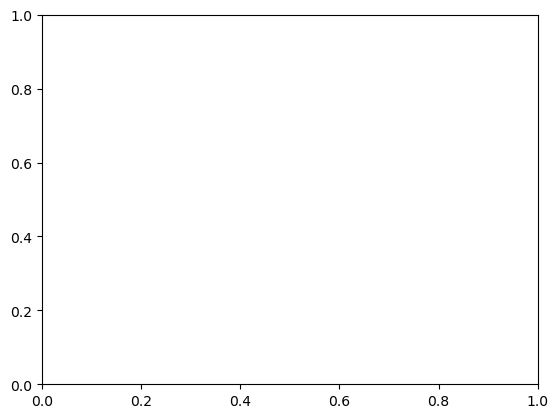

In [8]:
%%time
fitting_N = 1
if fitting_N:

    c_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.68, 
                              size = 10, 
                              interpolated = True,
                               )
    
    save(c_N, 'data/5_scan_N_68.json')
    print("95")
    c95_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.95, 
                               size = 10, 
                               )
    save(c95_N, 'data/5_scan_N_95.json')
else:
    c_N = read('data/5_scan_N_68.json')
    c95_N = read('data/5_scan_N_95.json')

In [9]:
datasets.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3000e+00,,0.000e+00,nan,nan,False,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,8.3631e+01,deg,6.348e-04,nan,nan,True,False,False,
spatial,lat_0,2.2018e+01,deg,8.726e-04,-9.000e+01,9.000e+01,True,False,False,
spatial,sigma,1.9174e-02,deg,4.267e-03,0.000e+00,nan,True,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,False,
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,True,True,False,


In [10]:
datasets_N.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str12,str13,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.2254e+00,,7.611e-02,nan,nan,False,False,False,
spectral,amplitude,9.2719e-13,cm-2 s-1 TeV-1,9.566e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,8.3631e+01,deg,0.000e+00,nan,nan,True,False,False,
spatial,lat_0,2.2018e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,False,
spatial,sigma,1.9174e-02,deg,0.000e+00,0.000e+00,nan,True,False,False,
spatial,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,False,
spatial,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,False,
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,True,True,False,


# Stat Contours

In [11]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'
color_nui = 'navy'; color_nui_e = 'cornflowerblue' # 'cornflowerblue'
color_rnd = 'darkgreen'
color_input = 'darkorange'
color_ereco = 'darkorange' ; color_ereco_e = 'gold'

In [12]:
if not fitting and not fitting_N:

    plt.figure()
    plt.plot(c['x'], c['y'], '.-', label='0.68', color = color_standard)
    plt.plot(c95['x'], c95['y'], '.-', label='0.95', color = color_standard_e)
    plt.plot(c_N['x'], c_N['y'], '.-', label='Ereco 0.68', color = color_ereco)
    plt.plot(c95_N['x'], c95_N['y'], '.-', label='Ereco 0.95', color = color_ereco_e)
    
    plt.legend(fontsize=9, loc='best')

In [13]:
if fitting:# and fitting_N:

    plt.figure()
    for ii, seg in enumerate(c.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c.levels[ii], color = color_standard)
    for ii, seg in enumerate(c95.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c95.levels[ii], color = color_standard_e)    


    plt.legend(fontsize=9, loc='best')